# Convolutional network

Here, we examine the performance of CNN's on our dataset. The goal is to examine performance in situation where graph information is not refined, that is we keep all FC links.

In [1]:
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [4]:
from torch.utils.tensorboard import SummaryWriter

In [5]:
from sklearn.model_selection import StratifiedKFold

## Load data

In [6]:
DATA_FOLDER = '../data'
PICKLE_FOLDER = '../pickles'

In [7]:
with open(f'{PICKLE_FOLDER}/fc-pearson.pickle', 'rb') as f:
    fc_pearson = pickle.load(f)

In [8]:
with open(f'{PICKLE_FOLDER}/fc-spearman.pickle', 'rb') as f:
    fc_spearman = pickle.load(f)

In [9]:
df_metadata = pd.read_csv(f'{DATA_FOLDER}/patients-cleaned.csv', index_col=0)

In [10]:
df_metadata.head(2)

age  sex  target
0  24.750    1       0
1  27.667    1       0

## Split data

In [11]:
with open(f'{PICKLE_FOLDER}/test-indices.pickle', 'rb') as f:
    test_indices = pickle.load(f)

### Select the dataset to work with.

In [12]:
fc = fc_spearman.copy()

In [13]:
total_samples, total_brain_regions, _ = fc.shape

In [14]:
X_test_numpy = fc[test_indices]
y_test_numpy = df_metadata.iloc[test_indices]["target"].reset_index(drop=True)

In [15]:
train_indices = ~np.isin(np.arange(total_samples), test_indices)
X_train_numpy = fc[train_indices]
y_train_numpy = df_metadata.iloc[train_indices]["target"].reset_index(drop=True)

## Augment data

In [16]:
# Zero auto-correlations.
# for i in range(total_brain_regions):
#     X_train_numpy[:, i, i] = 0
#     X_test_numpy[:, i, i] = 0

For some reason zeroing auto-correlations renders the model unconvergable.

## Define model

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [51]:
class ConvNet(nn.Module):

    def __init__(self, hidden_channels):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_channels, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=(3,3), padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=hidden_channels, out_channels=1, kernel_size=(3,3), padding=(1,1))

        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(1,1)) 
        # 90 -> 44 -> 21 -> 10

        self.fc1 = nn.Linear(in_features=1 * 87 * 87, out_features=2)

    def forward(self, x):
        x = self.pool(F.gelu(self.conv1(x)))
        x = self.pool(F.gelu(self.conv2(x)))
        x = self.pool(F.gelu(self.conv3(x)))

        x = x.view(-1, 1 * 87 * 87)

        x = self.fc1(x)
        return x

In [37]:
class ConvNet(nn.Module):

    def __init__(self, hidden_channels):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=hidden_channels, kernel_size=(1,3), padding=(0,1))
        self.conv2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=(1,3), padding=(0,1))
        self.conv3 = nn.Conv2d(in_channels=hidden_channels, out_channels=1, kernel_size=(1,3), padding=(0,1))

        self.pool = nn.MaxPool2d(kernel_size=(1,3), stride=(1,2)) 
        # 90 -> 44 -> 21 -> 10

        self.fc1 = nn.Linear(in_features=1 * 90 * 10, out_features=2)

    def forward(self, x):
        x = self.pool(F.gelu(self.conv1(x)))
        x = self.pool(F.gelu(self.conv2(x)))
        x = self.pool(F.gelu(self.conv3(x)))

        x = x.view(-1, 1 * 90 * 10)

        x = self.fc1(x)
        return x

    # There are frequent convergence issues, so we init weights manually.
    def init_weights(self, layer):
        if type(layer) == nn.Conv2d:
            layer.weight.data.fill_(0.01)


In [52]:
ConvNet(hidden_channels=3)

ConvNet(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7569, out_features=2, bias=True)
)

## Model evaluation

In [53]:
def evaluation_metrics(predicted, labels):
    pred_positives = predicted == 1
    label_positives = labels == 1

    tp = (pred_positives & label_positives).sum().item()
    tn = (~pred_positives & ~label_positives).sum().item()
    fp = (pred_positives & ~label_positives).sum().item()
    fn = (~pred_positives & label_positives).sum().item()

    return tp, tn, fp, fn

## Model training

In [54]:
NUM_FOLDS = 7   # 140 = (120 + 20)

In [56]:
skf = StratifiedKFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)

In [57]:
# Settings.
EPOCHS = 200
LR = 0.0001
MOMENTUM = 'adam'

BATCH_SIZE = 8

VALIDATE_FREQ = 10

HIDDEN_CHANNELS = 3

In [59]:
# Experiment.
EXP_ID = 4

In [60]:
for kfold, (train_index, val_index) in enumerate(skf.split(X_train_numpy, y_train_numpy)):
    # Init model.
    net = ConvNet(HIDDEN_CHANNELS)
    net.to(device)
    optimizr = optim.Adam(net.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    # Init TB writer.
    foldername = f'id={EXP_ID:03d},fold={kfold},bs={BATCH_SIZE},e={EPOCHS},lr={LR},mom={MOMENTUM}'
    writer = SummaryWriter(f"../runs/conv/{foldername}")
    with open(f"../runs/conv/{foldername}/architecture", 'w') as f:
        f.write(net.__str__())


    # Prepare data.
    X_train = torch.from_numpy(X_train_numpy[train_index]).unsqueeze(1).to(device, dtype=torch.float32)
    X_val = torch.from_numpy(X_train_numpy[val_index]).unsqueeze(1).to(device, dtype=torch.float32)

    y_train = torch.from_numpy(y_train_numpy[train_index].values).unsqueeze(1).to(device, dtype=torch.float32)
    y_val = torch.from_numpy(y_train_numpy[val_index].values).unsqueeze(1).to(device, dtype=torch.float32)
        
    trainloader = torch.utils.data.DataLoader([*zip(X_train, y_train)], batch_size=BATCH_SIZE, shuffle=True,num_workers=0)
    valloader = torch.utils.data.DataLoader([*zip(X_val, y_val)], batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Train.
    for epoch in range(EPOCHS):
        running_loss = 0.       

        for images, labels in trainloader:
            net.train()
            optimizr.zero_grad()

            outputs = net.forward(images)
            loss = criterion(outputs, labels.squeeze(-1).to(torch.long))
            
            loss.backward()
            optimizr.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        writer.add_scalar('training loss', epoch_loss, epoch)
    
        # Evaluate epoch.
        running_loss = 0.
        tp, tn, fp, fn = 0, 0, 0, 0
        total = 0

        for images, labels in valloader:
            net.eval()
            optimizr.zero_grad()

            outputs = net(images)

            loss = criterion(outputs, labels.squeeze(-1).to(torch.long))
            running_loss += loss.item()

            if (epoch+1) % VALIDATE_FREQ == 0:
                predicted = torch.where(outputs[:,0] < outputs[:,1], 1, 0)   # outputs.view(-1) > 0.5
                labels = labels.view(-1)

                # Update.
                tp_, tn_, fp_, fn_ = evaluation_metrics(predicted, labels)
                tp += tp_; tn += tn_; fp += fp_; fn += fn_
                total += labels.size(0)

        epoch_loss = running_loss / len(valloader)
        writer.add_scalar('validation loss', epoch_loss, epoch)
    
        if (epoch+1) % VALIDATE_FREQ == 0:
            writer.add_scalar('validation accuracy', (tp + tn) / total, epoch)
            writer.add_scalar('validation precision', tp / (tp + fp) if (tp + fp) > 0 else 0, epoch)
            writer.add_scalar('validation recall', tp / (tp + fn), epoch)
            
    print(f'Finished fold #{kfold+1}/{NUM_FOLDS}\n')

print('Finished training')


Finished fold #1/7

Finished fold #2/7

Finished fold #3/7

Finished fold #4/7

Finished fold #5/7

Finished fold #6/7

Finished fold #7/7

Finished training


## Activation maps

In [100]:
target_layer = net.conv3
cam = GradCAM(model=net, target_layer=target_layer)

c:\Users\janar\Documents\MFF\DiplomaThesis\BrainConnectivityMachineLearning\brain-connectivity\.venv\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


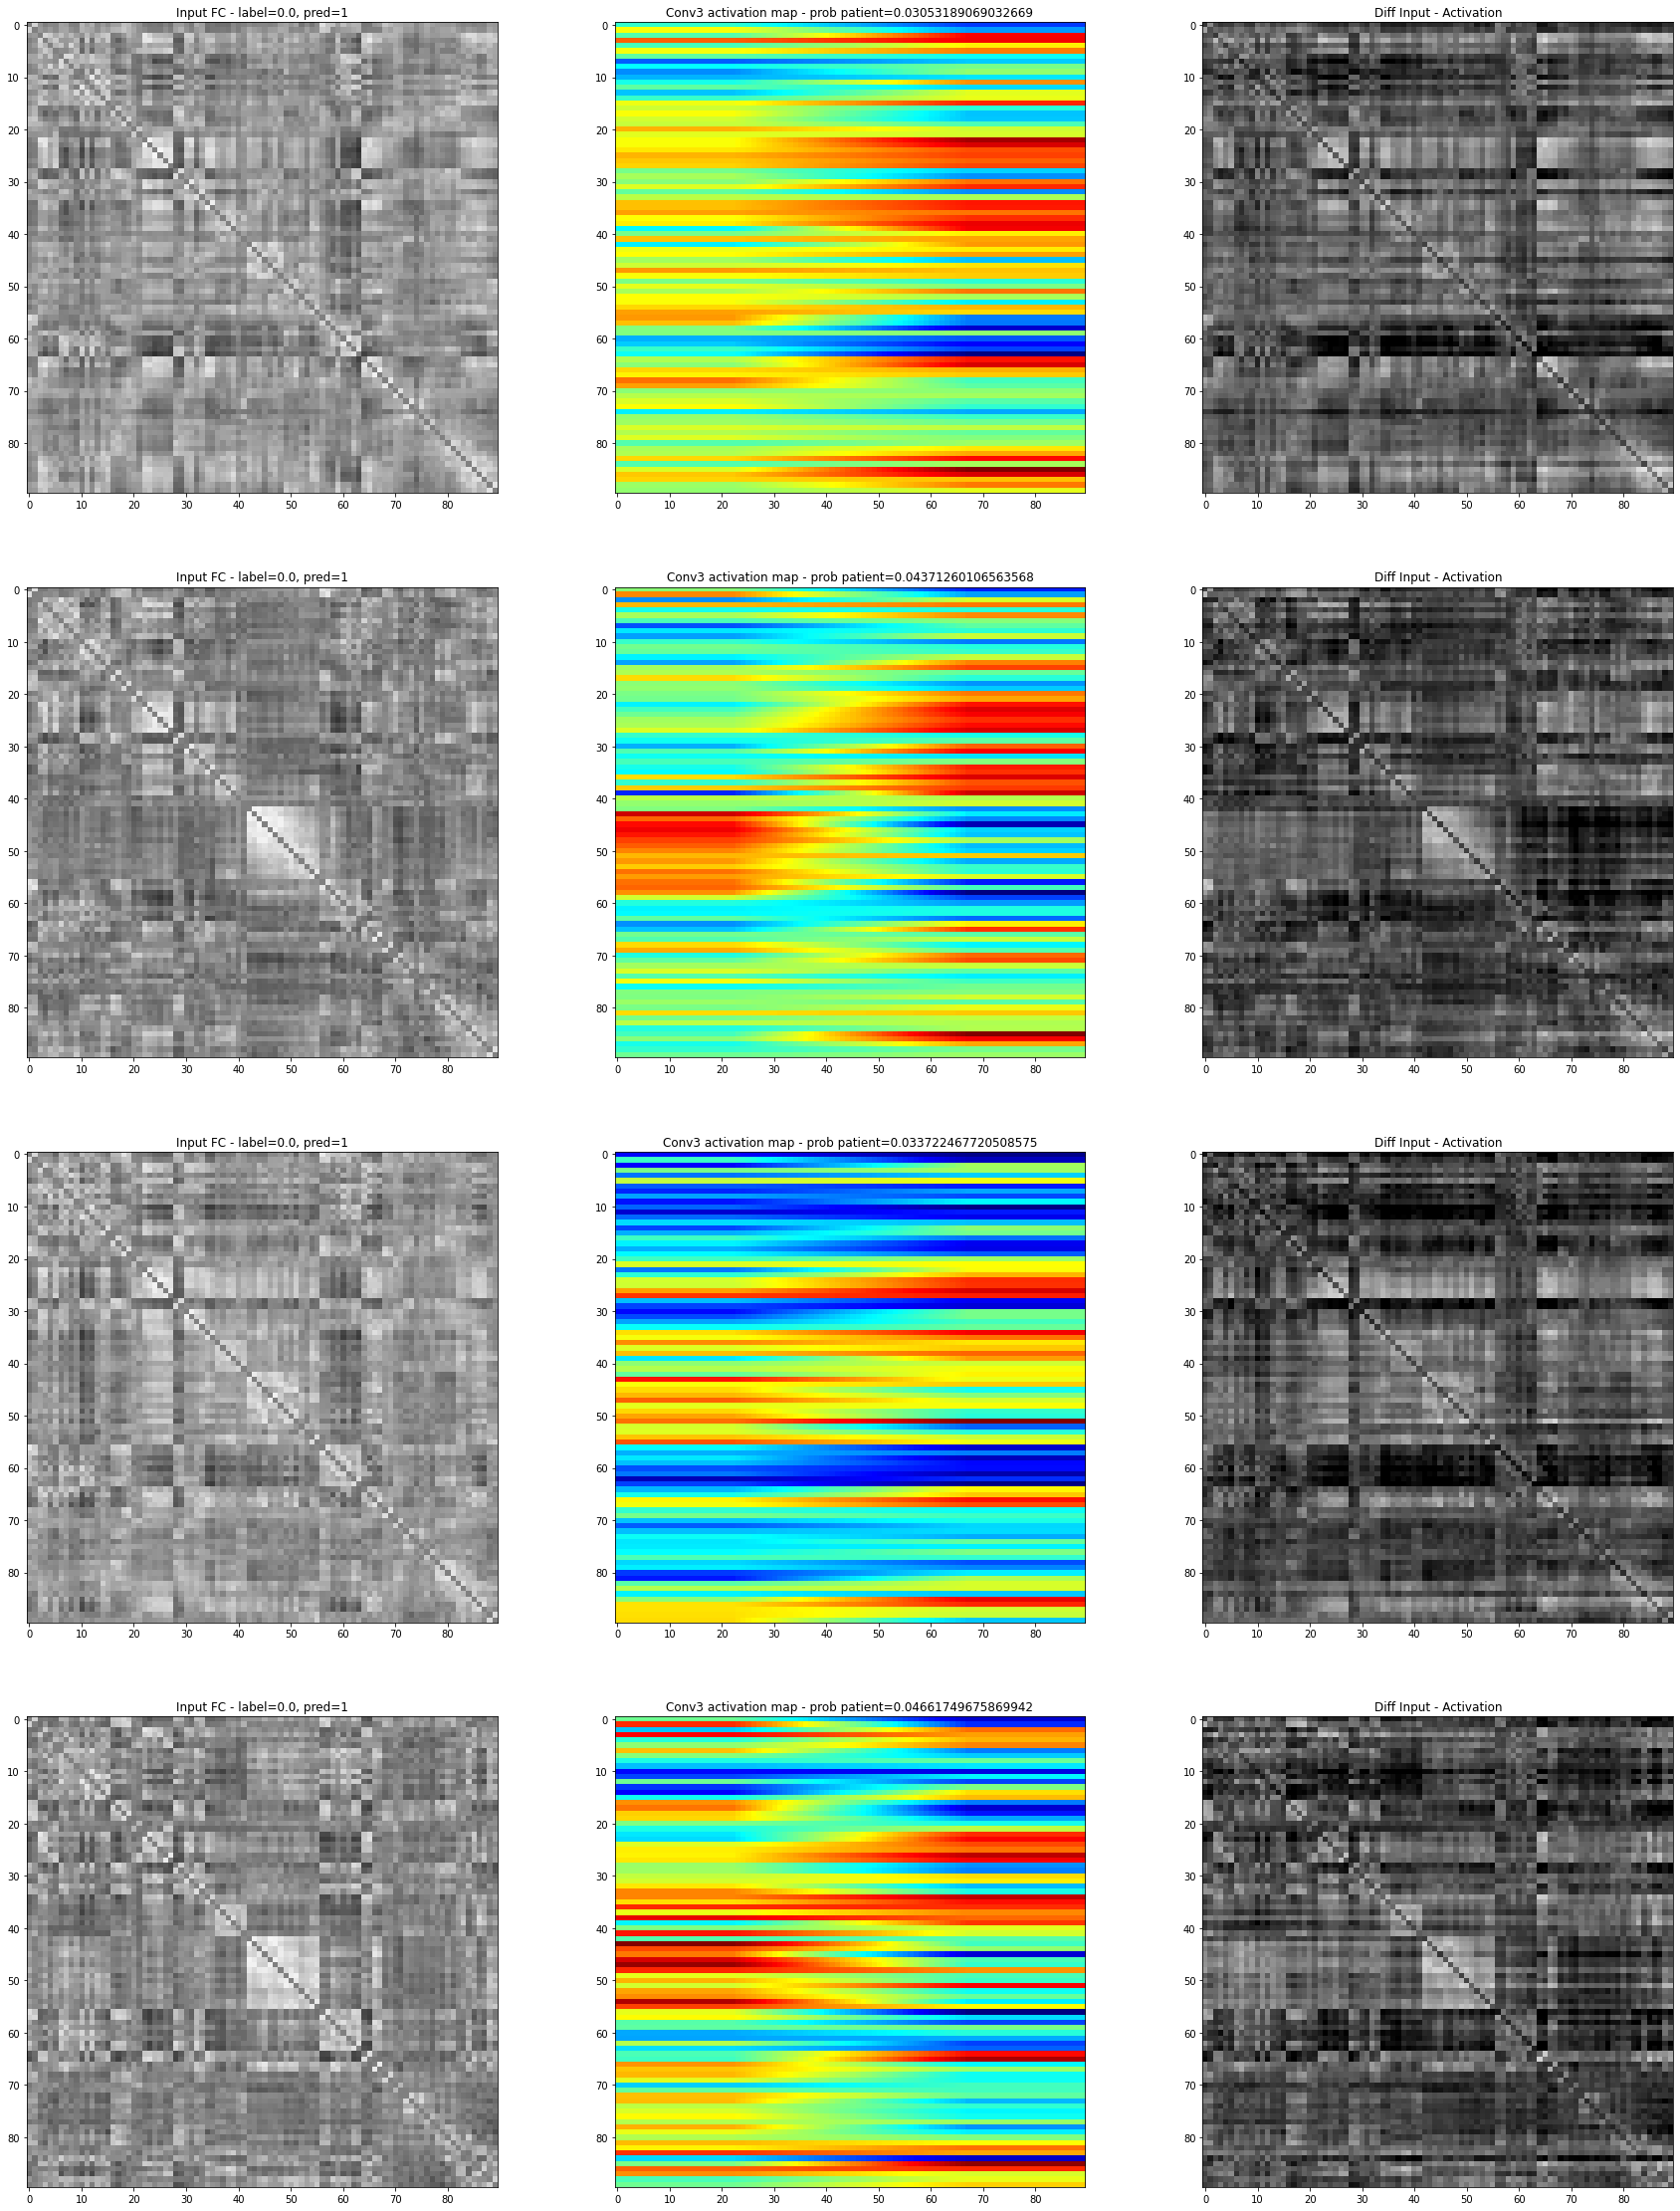

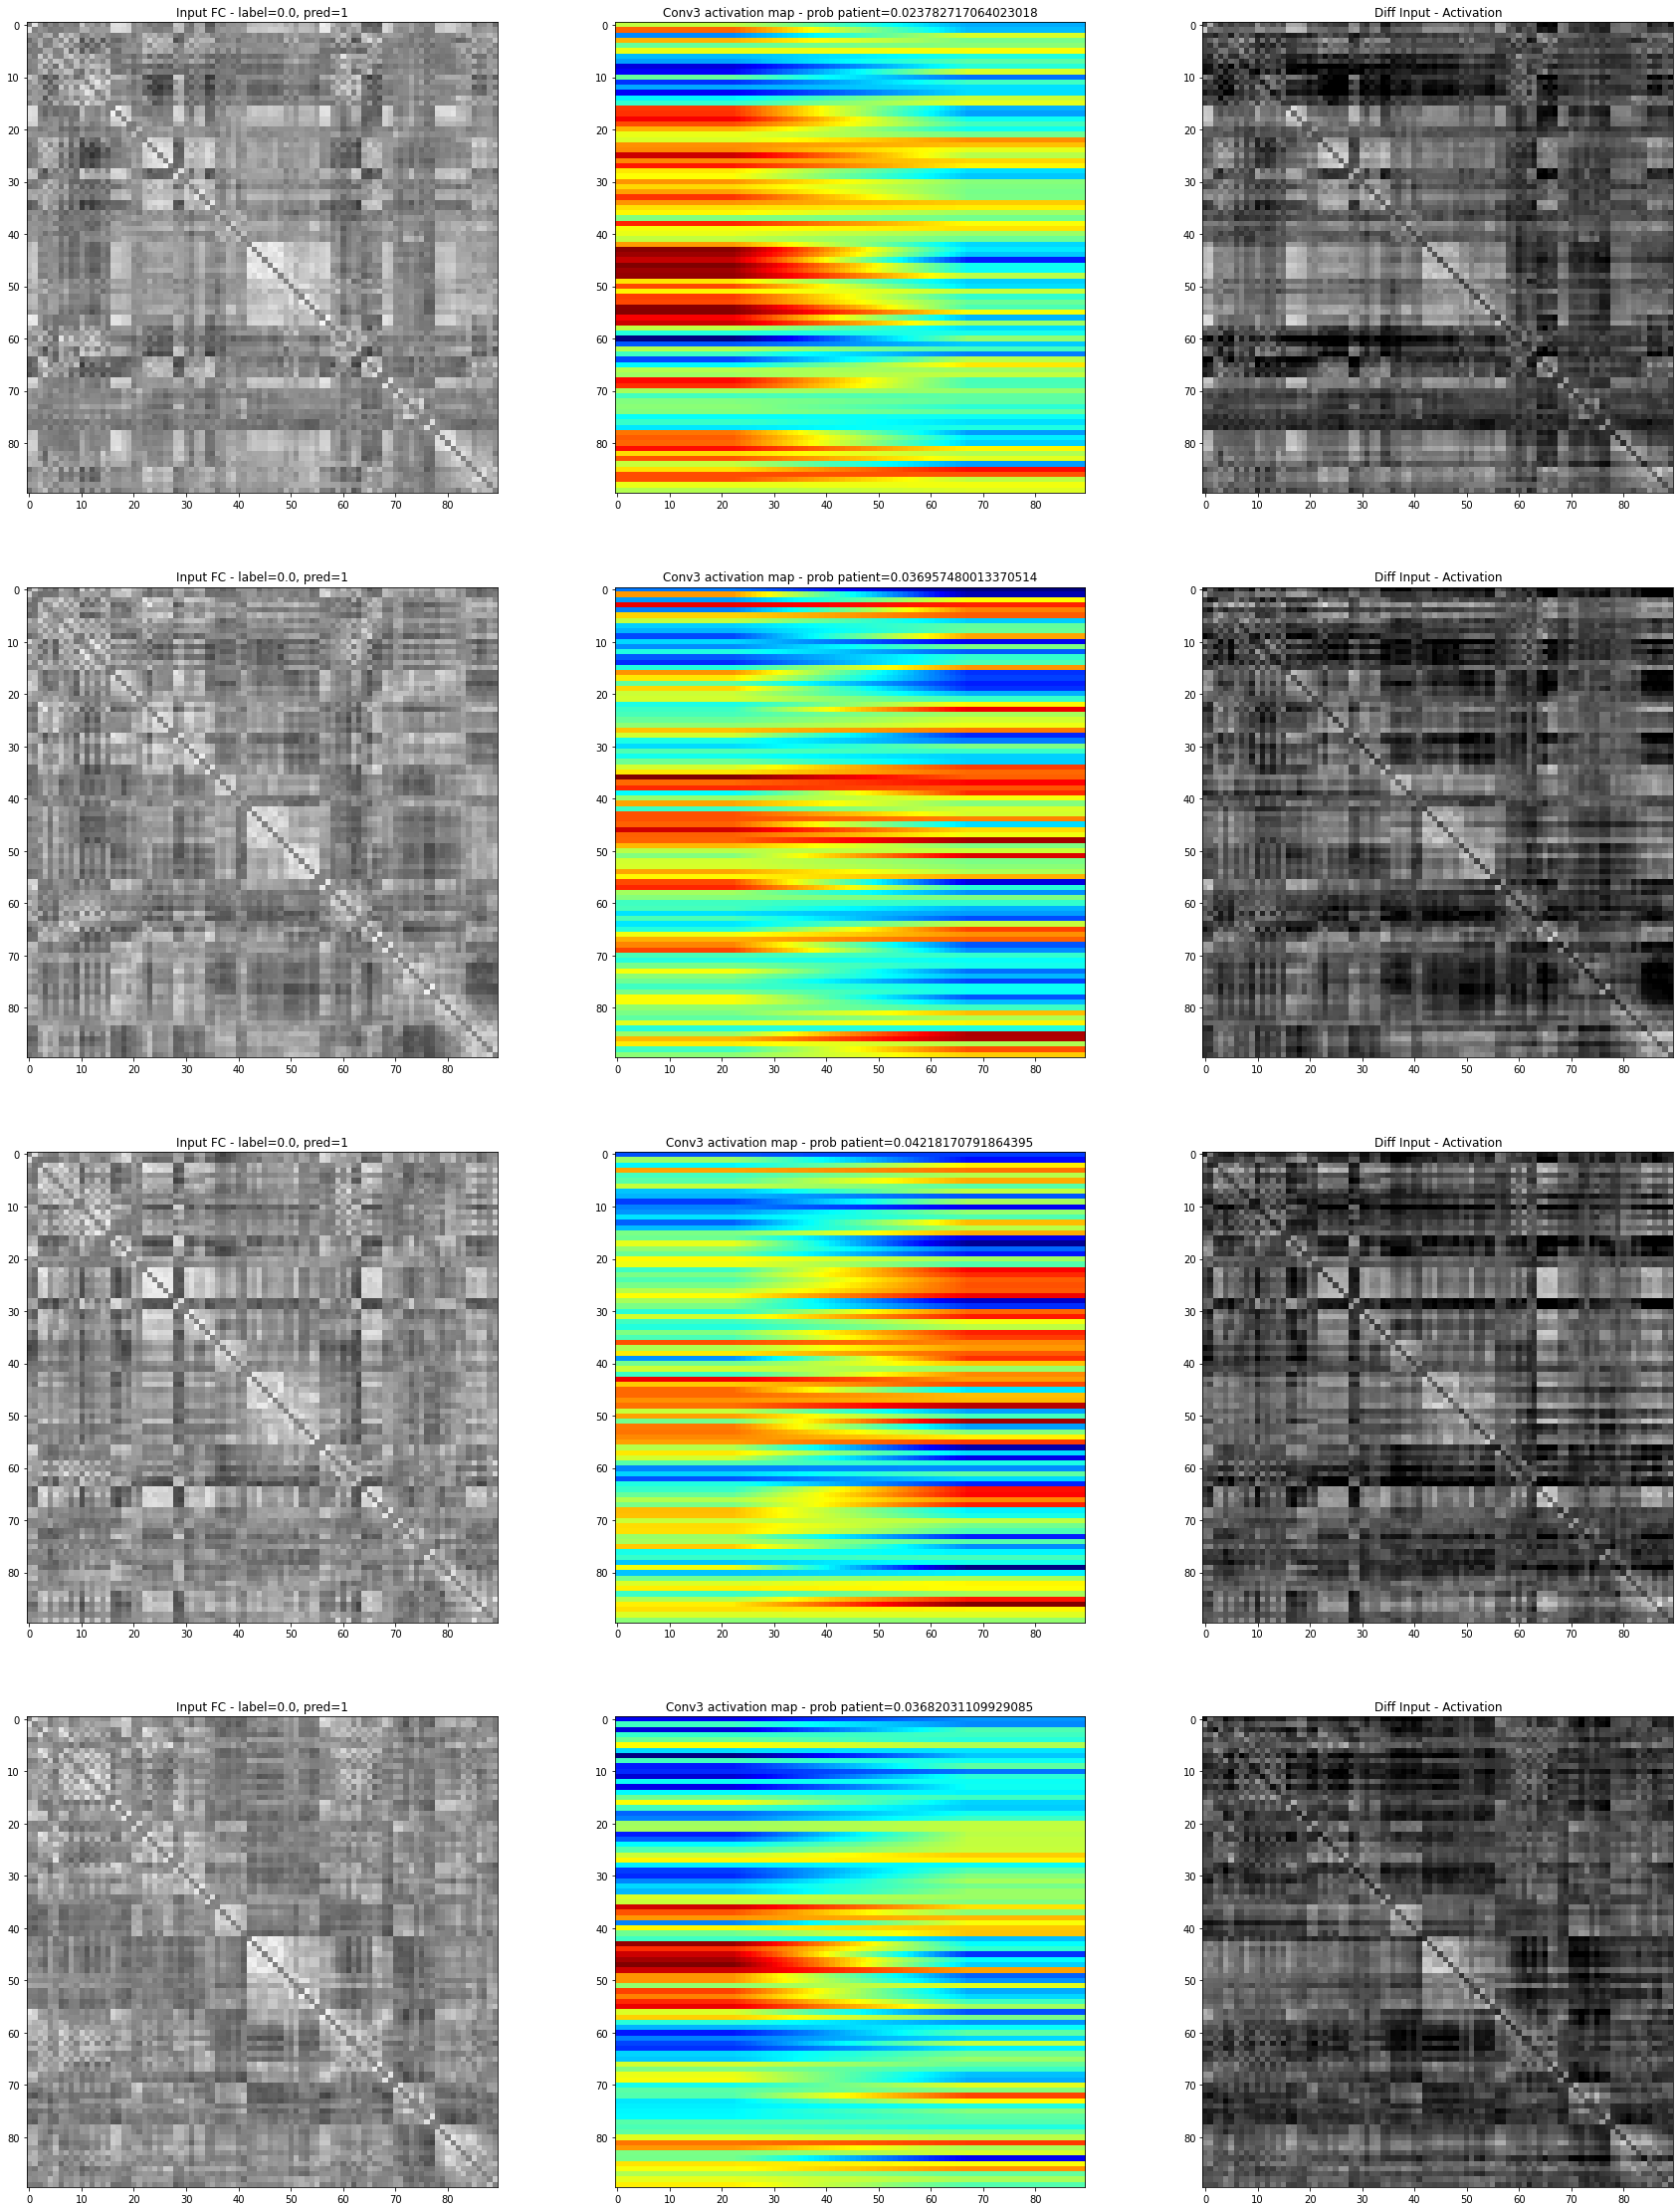

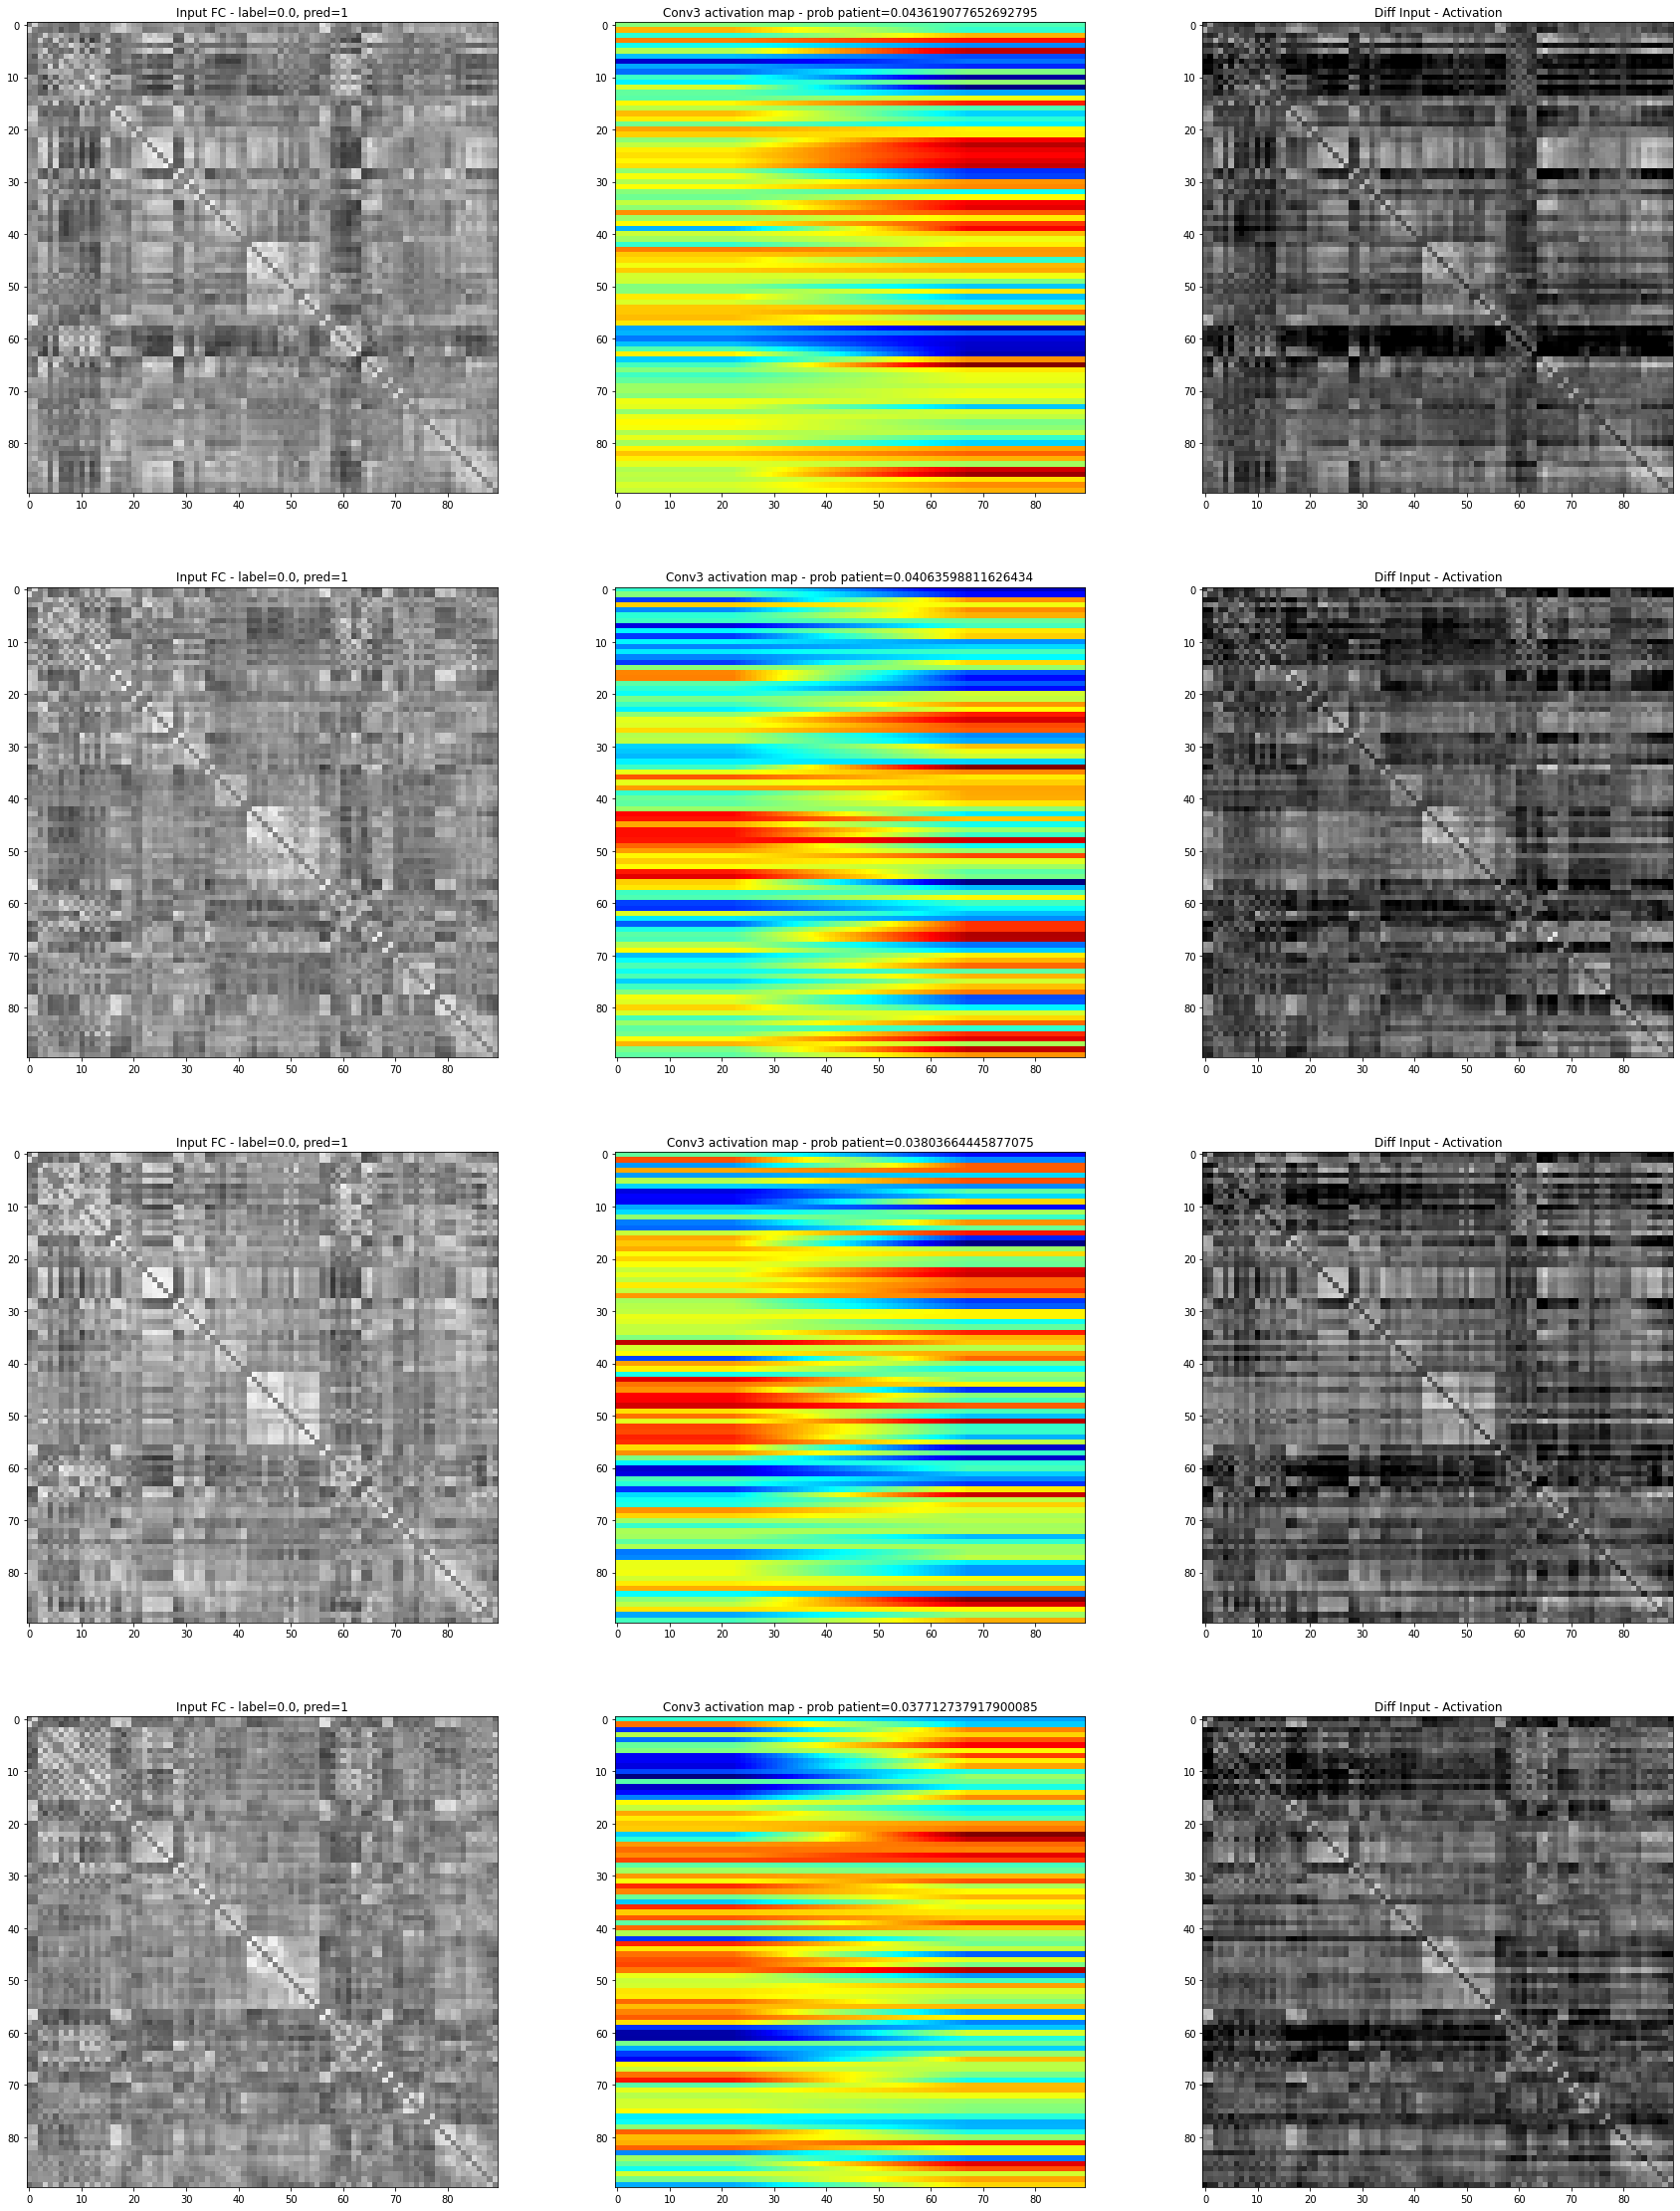

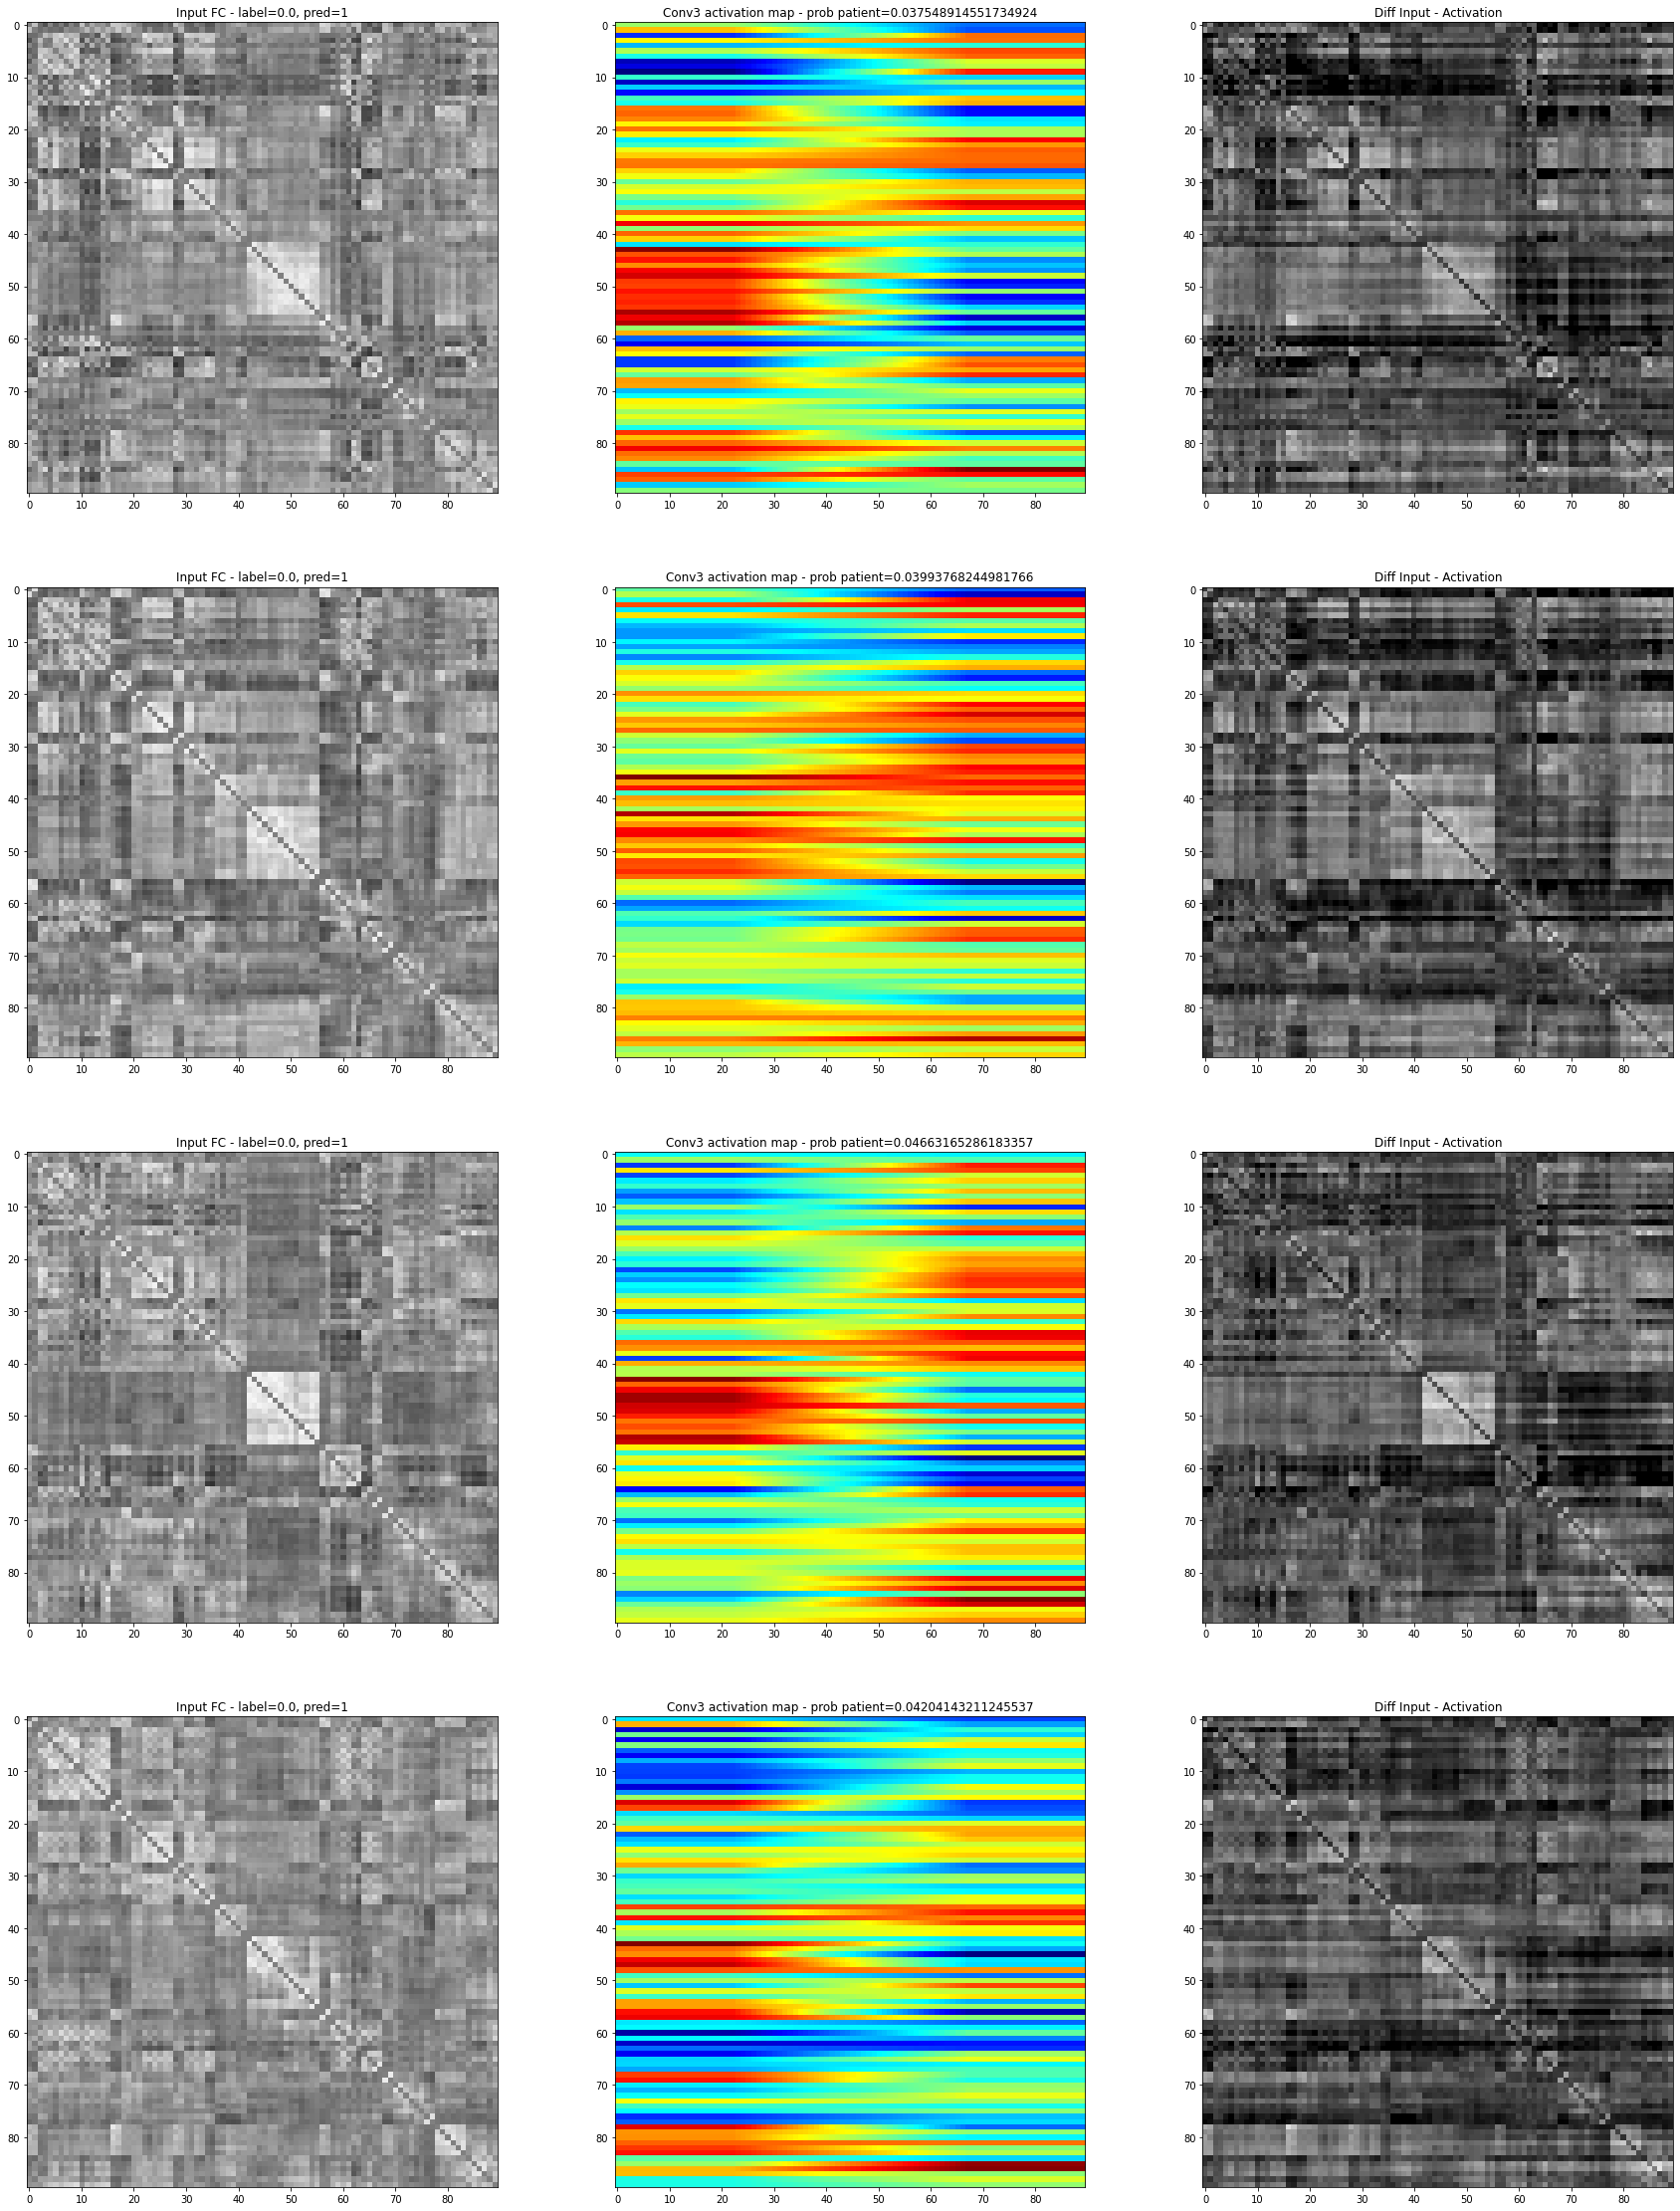

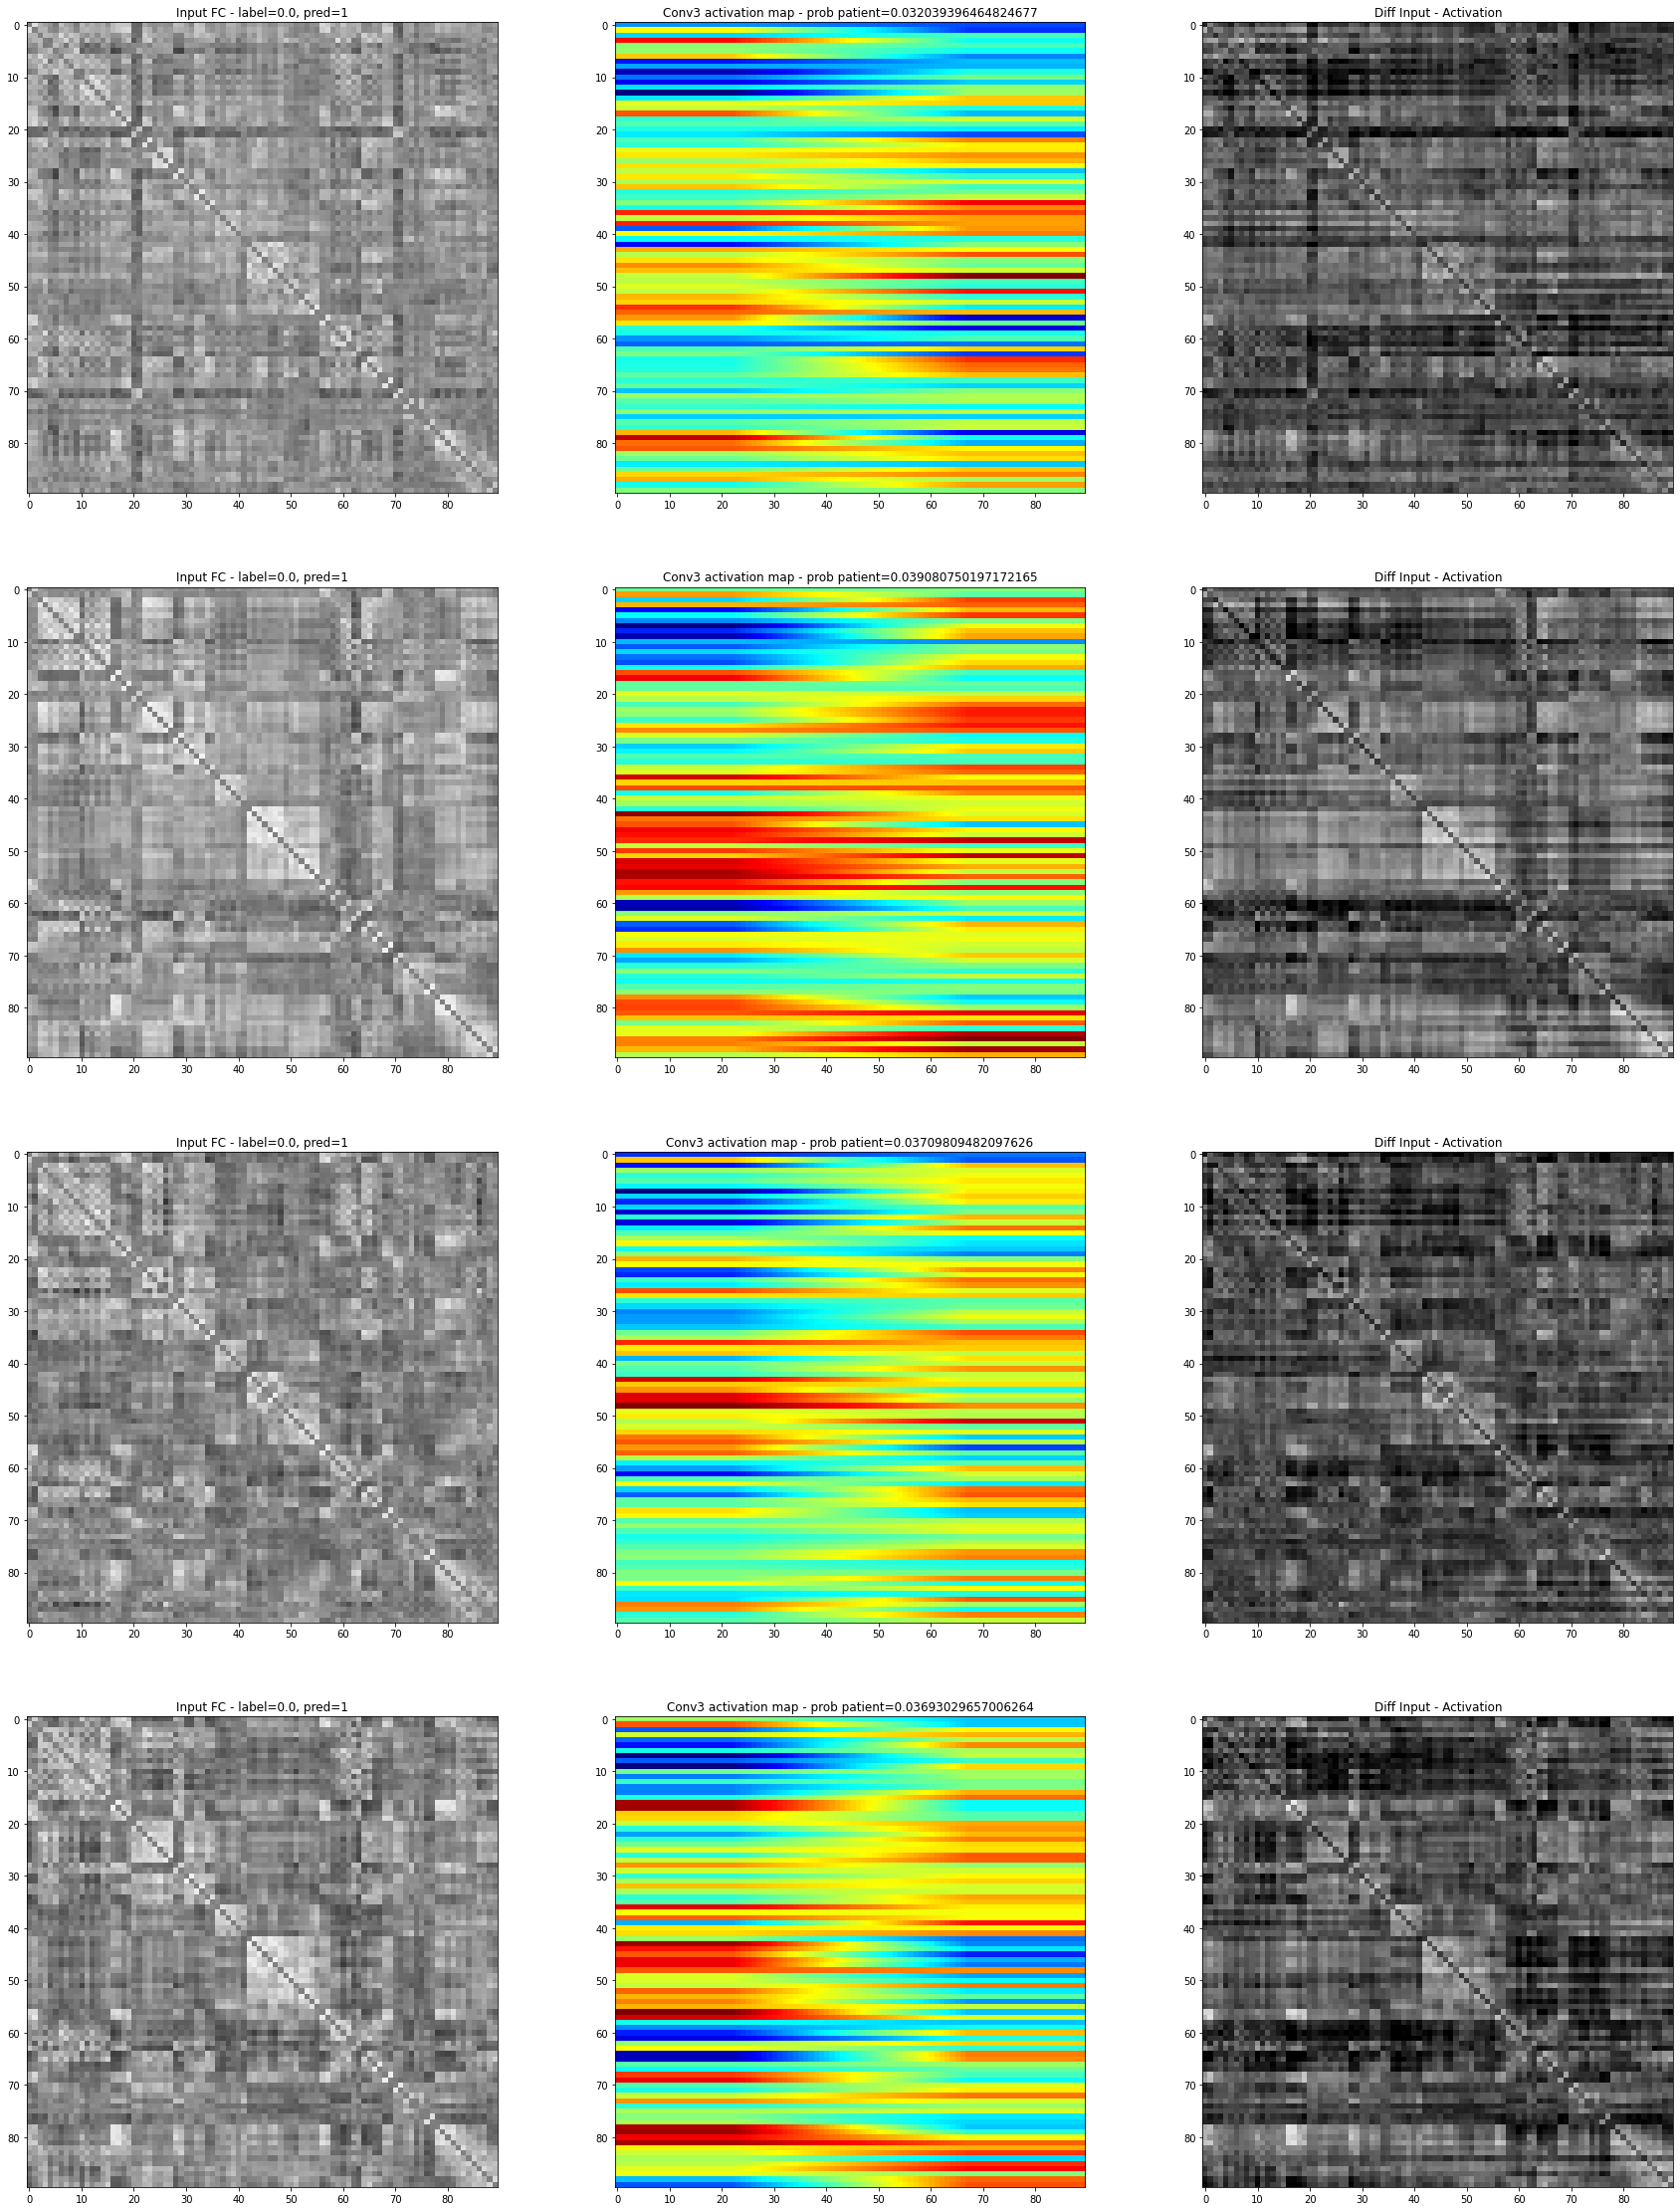

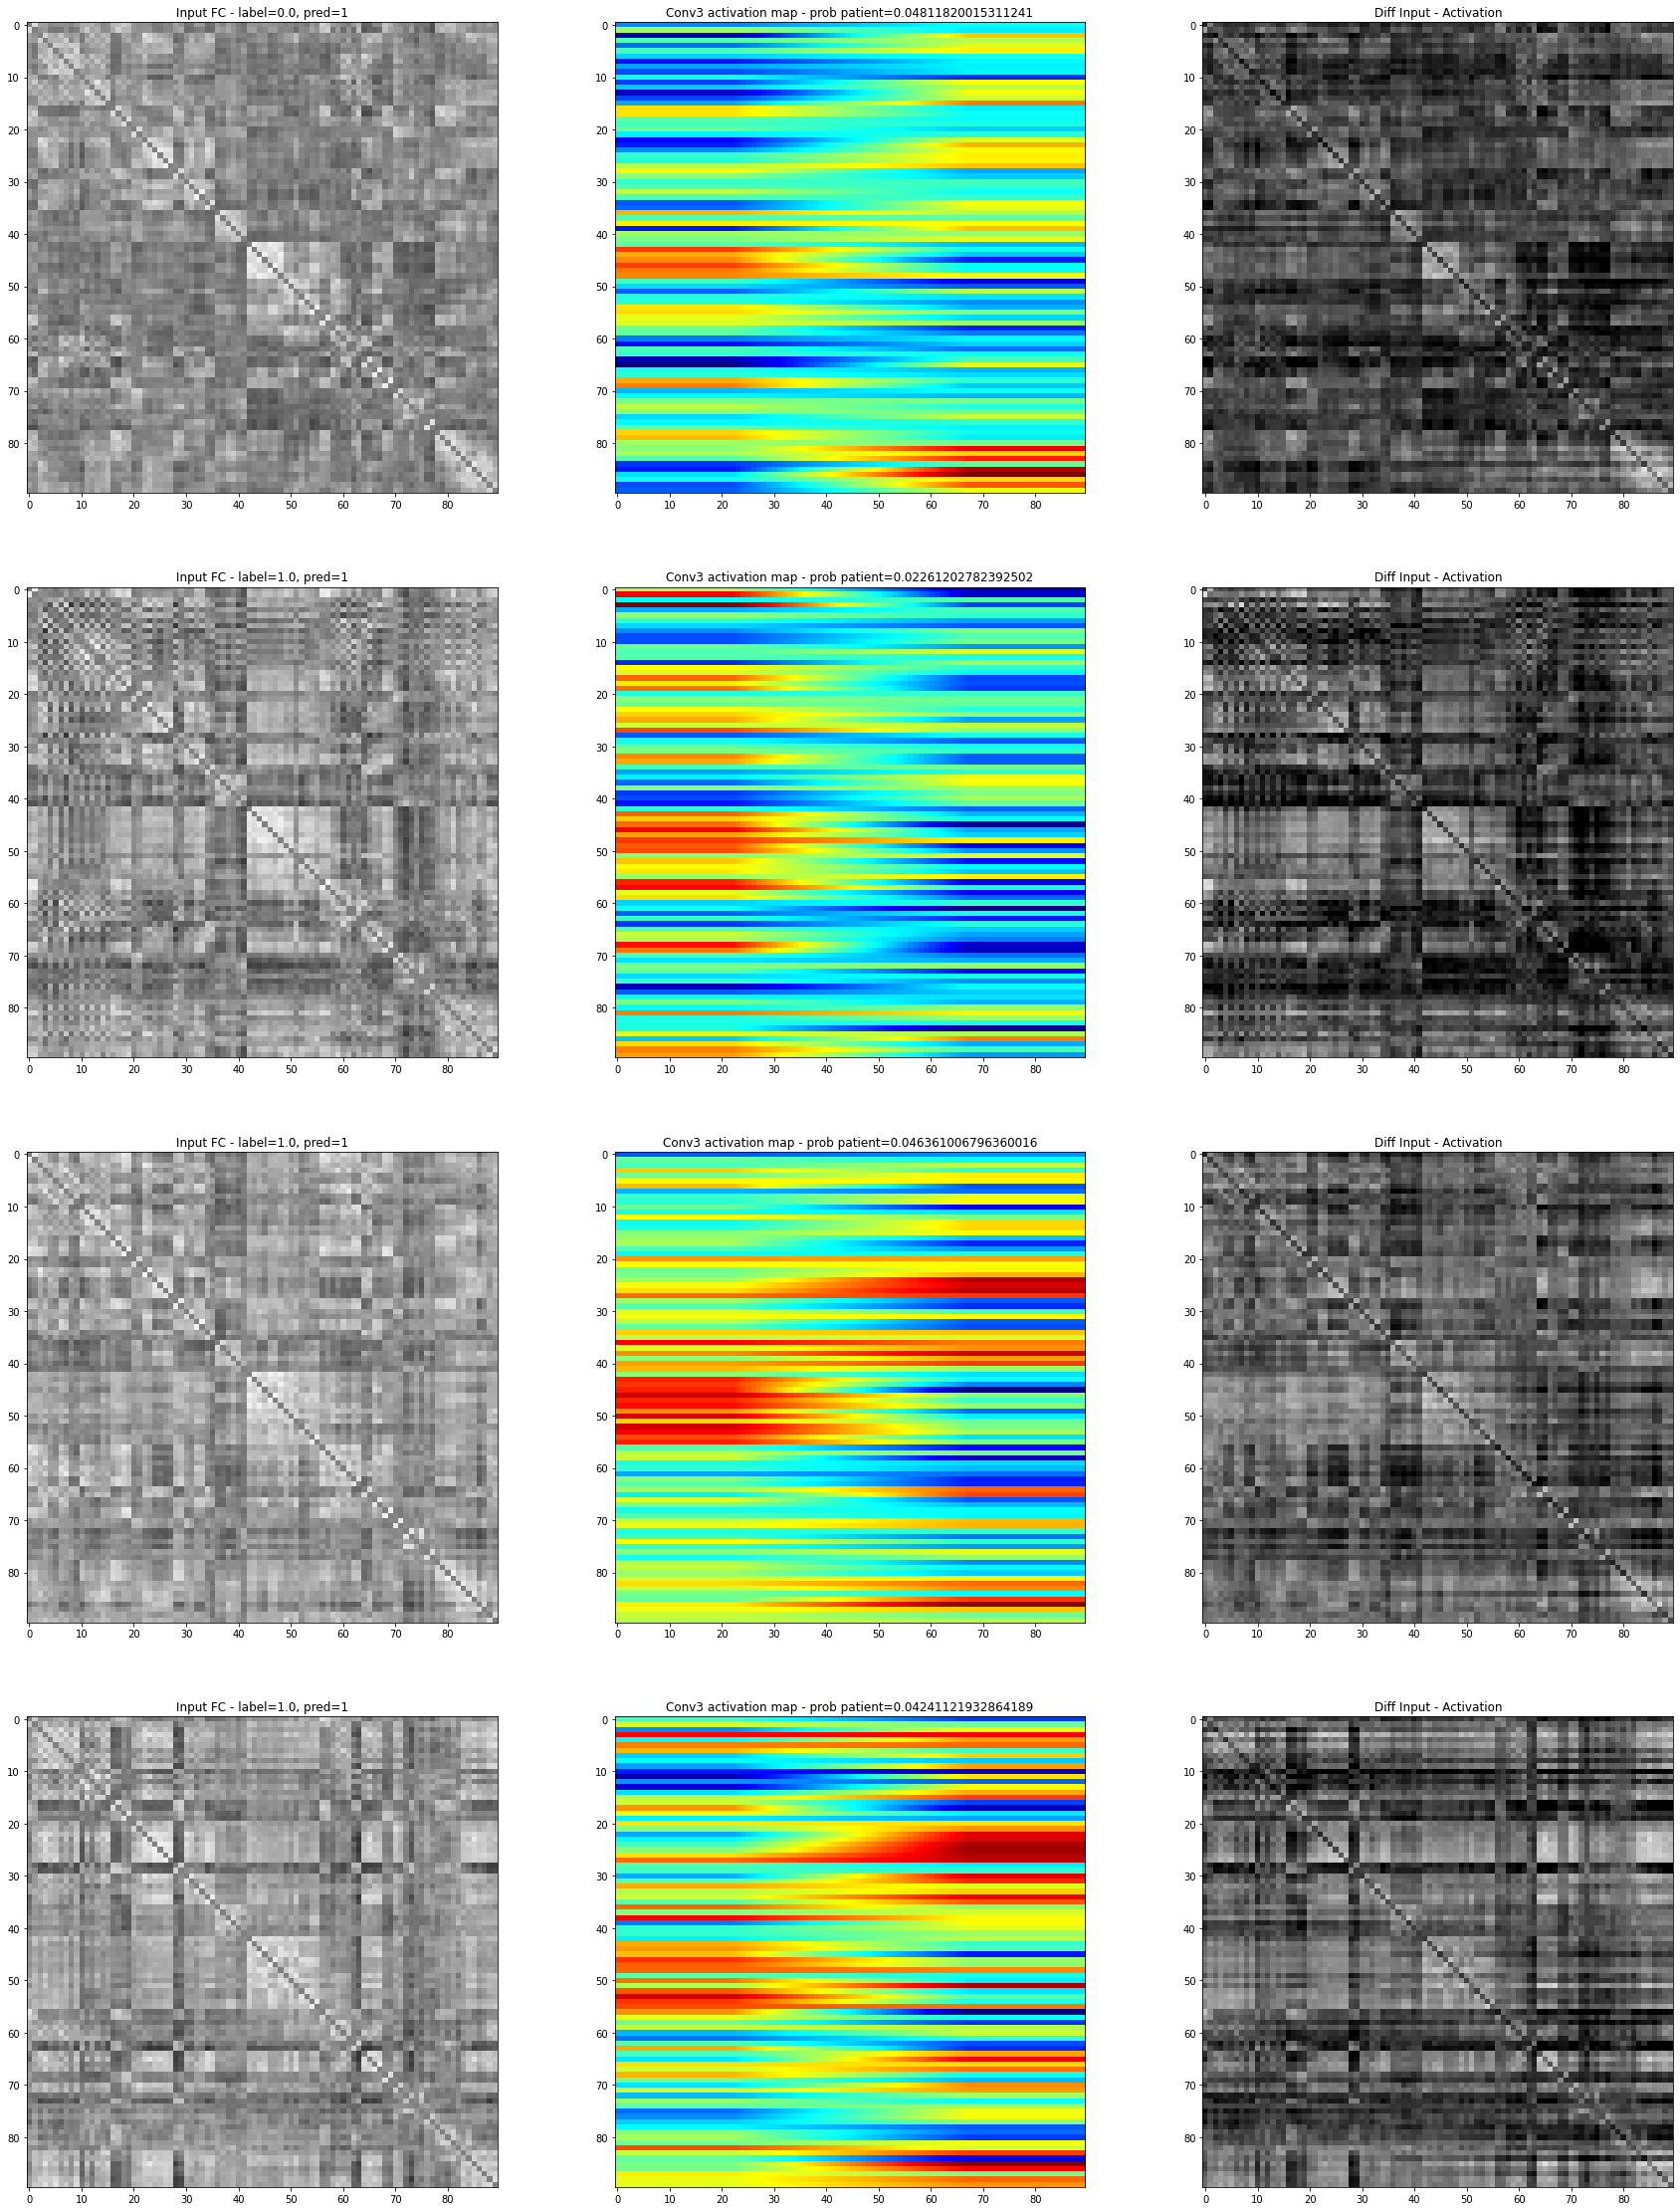

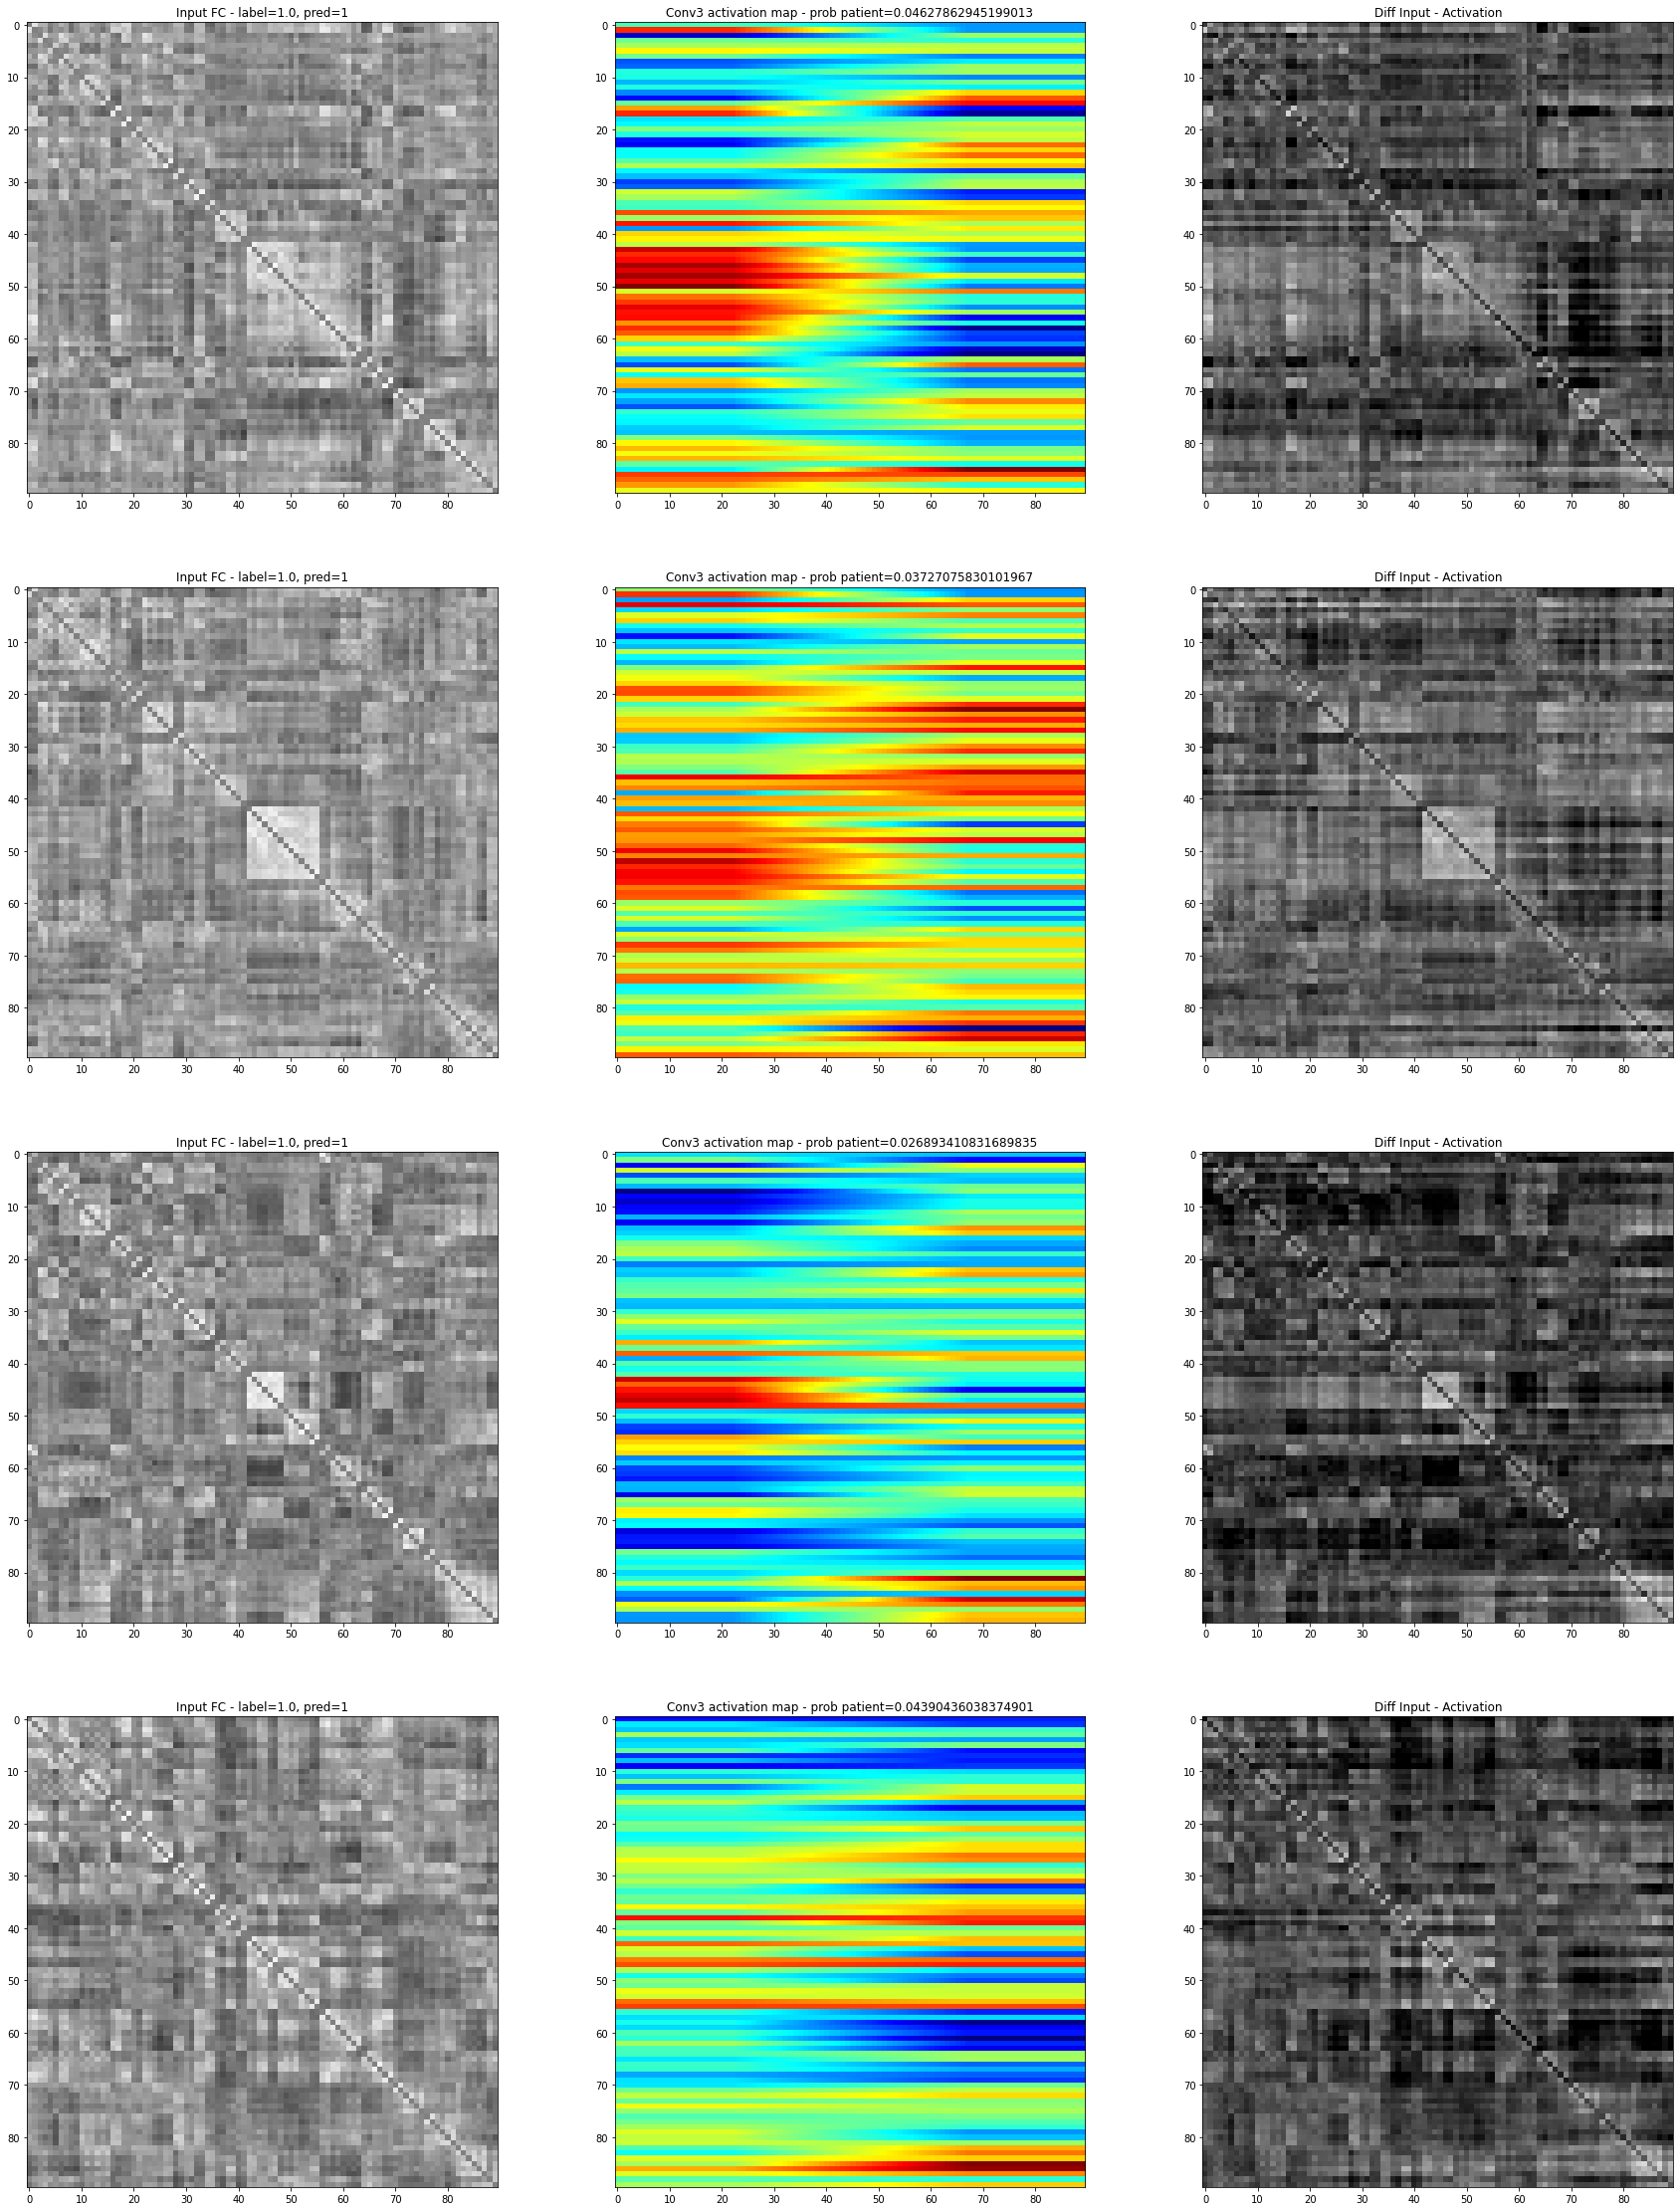

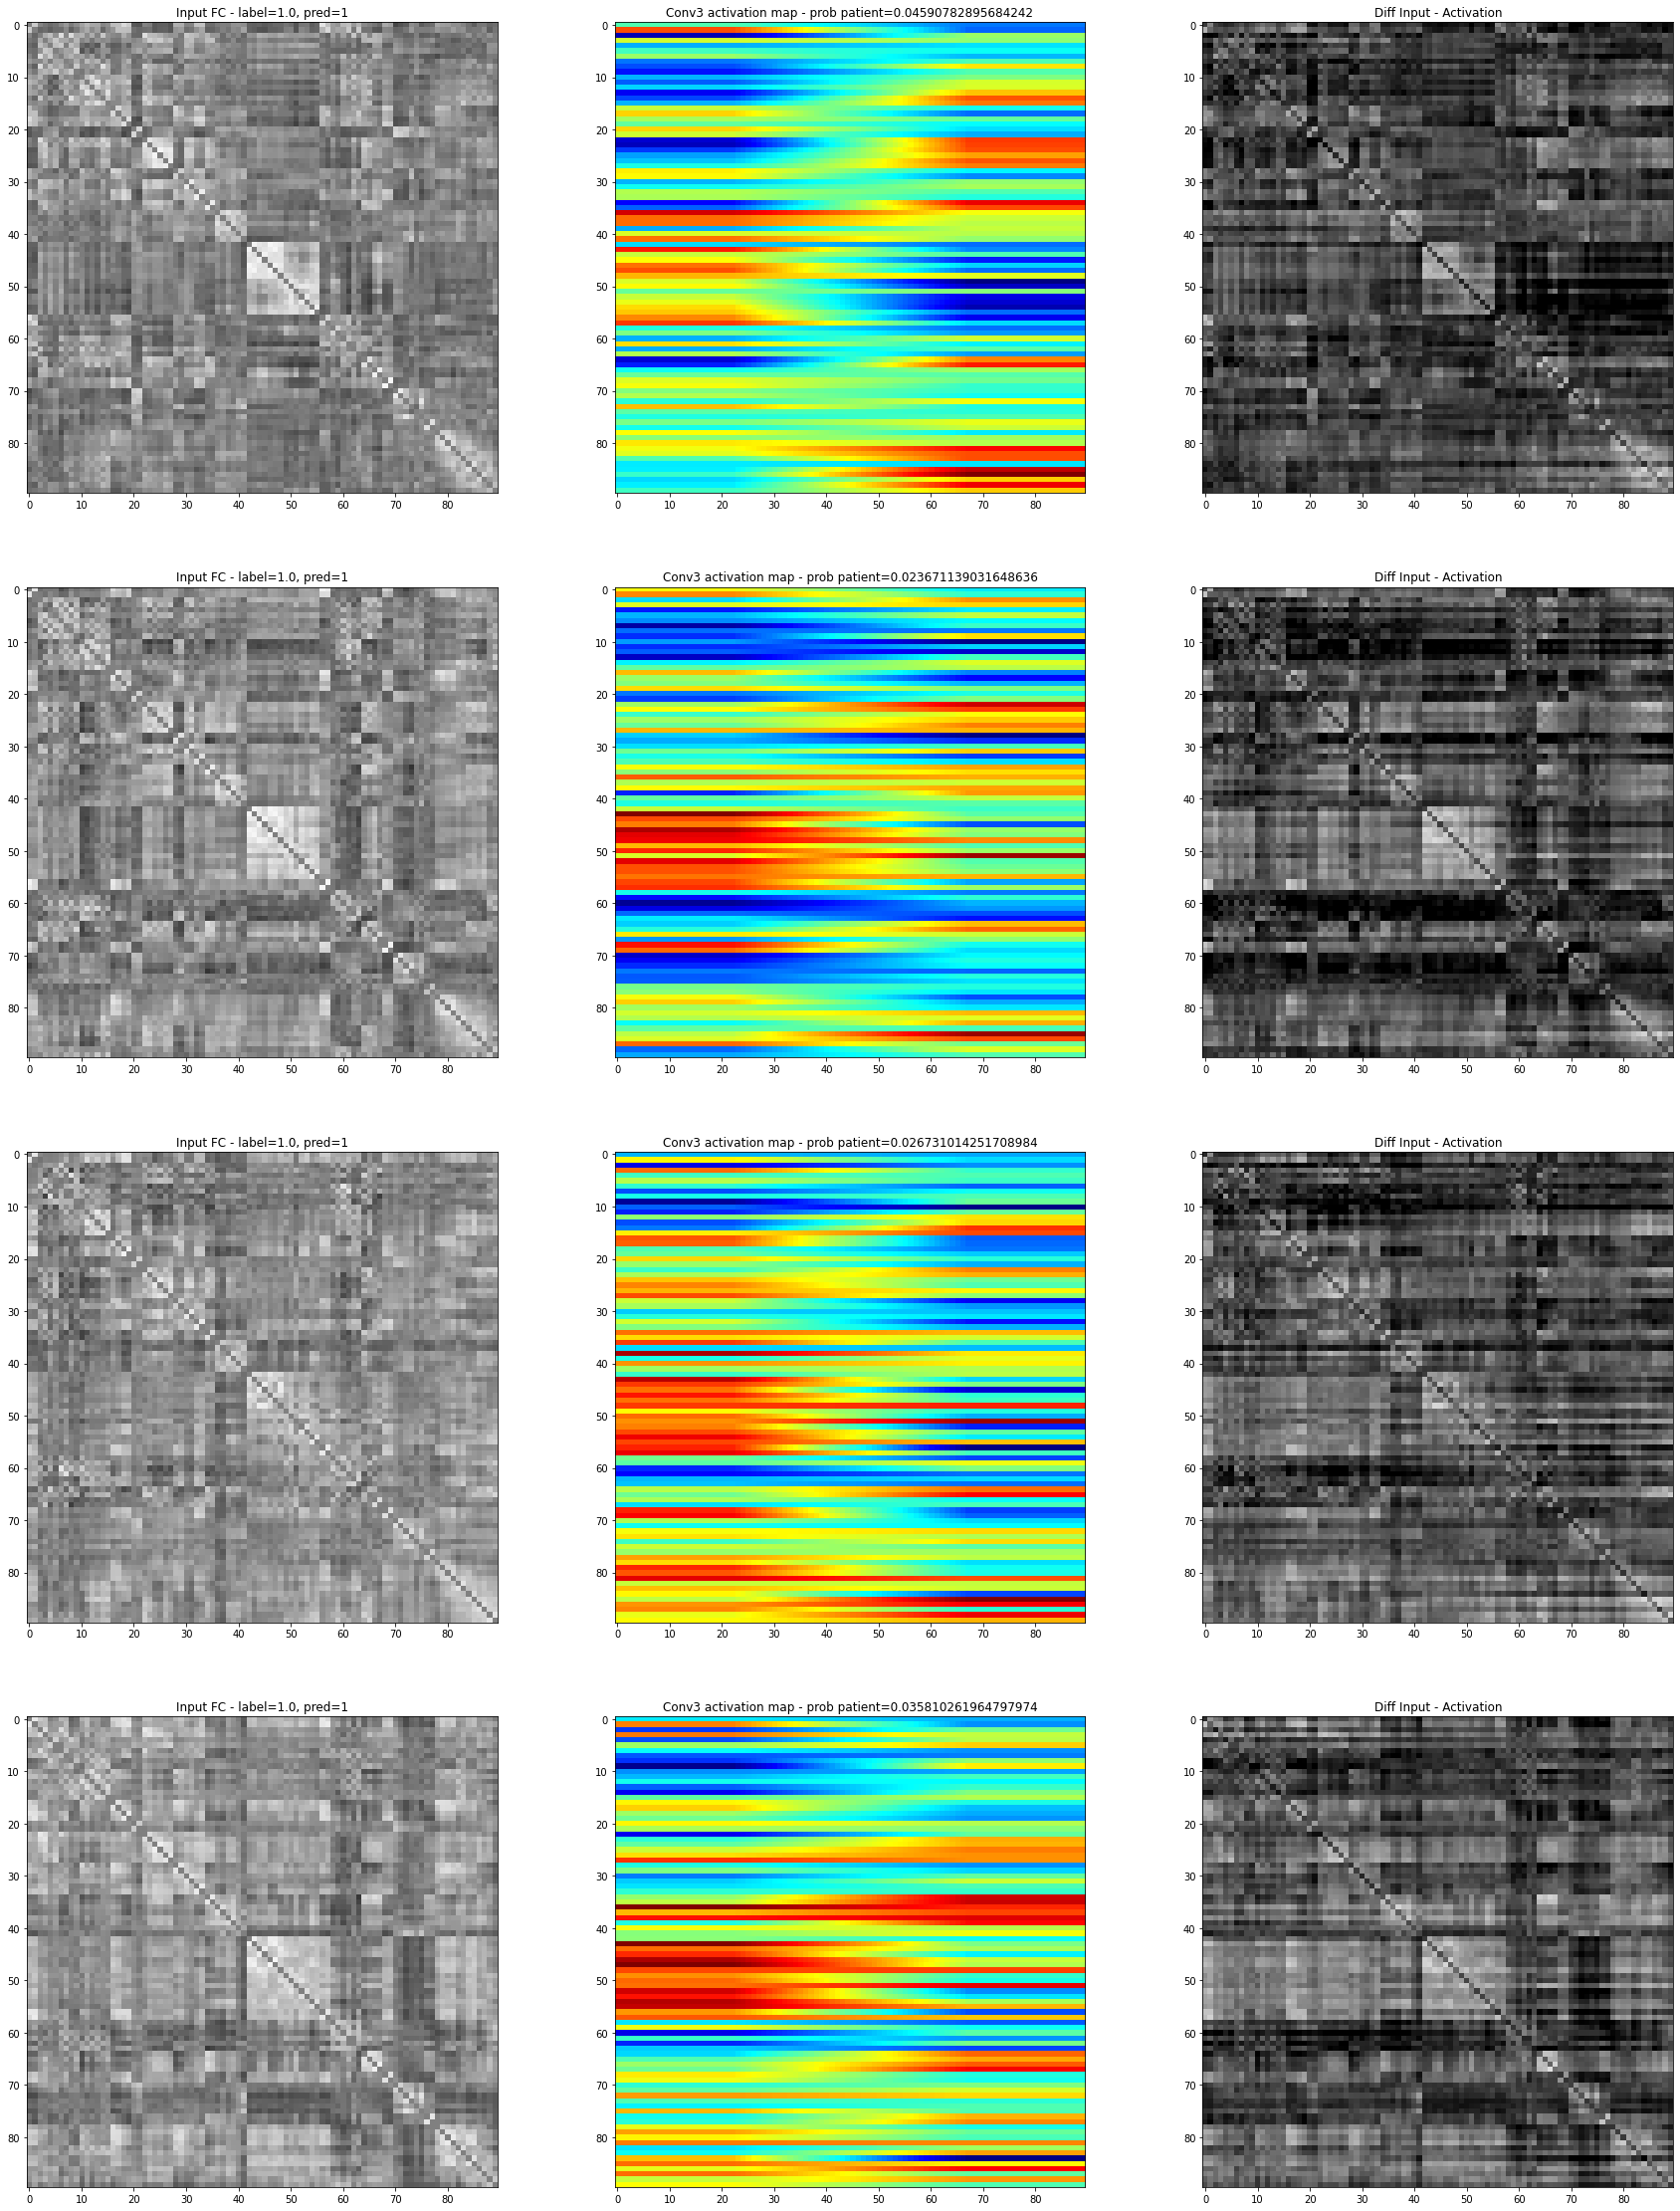

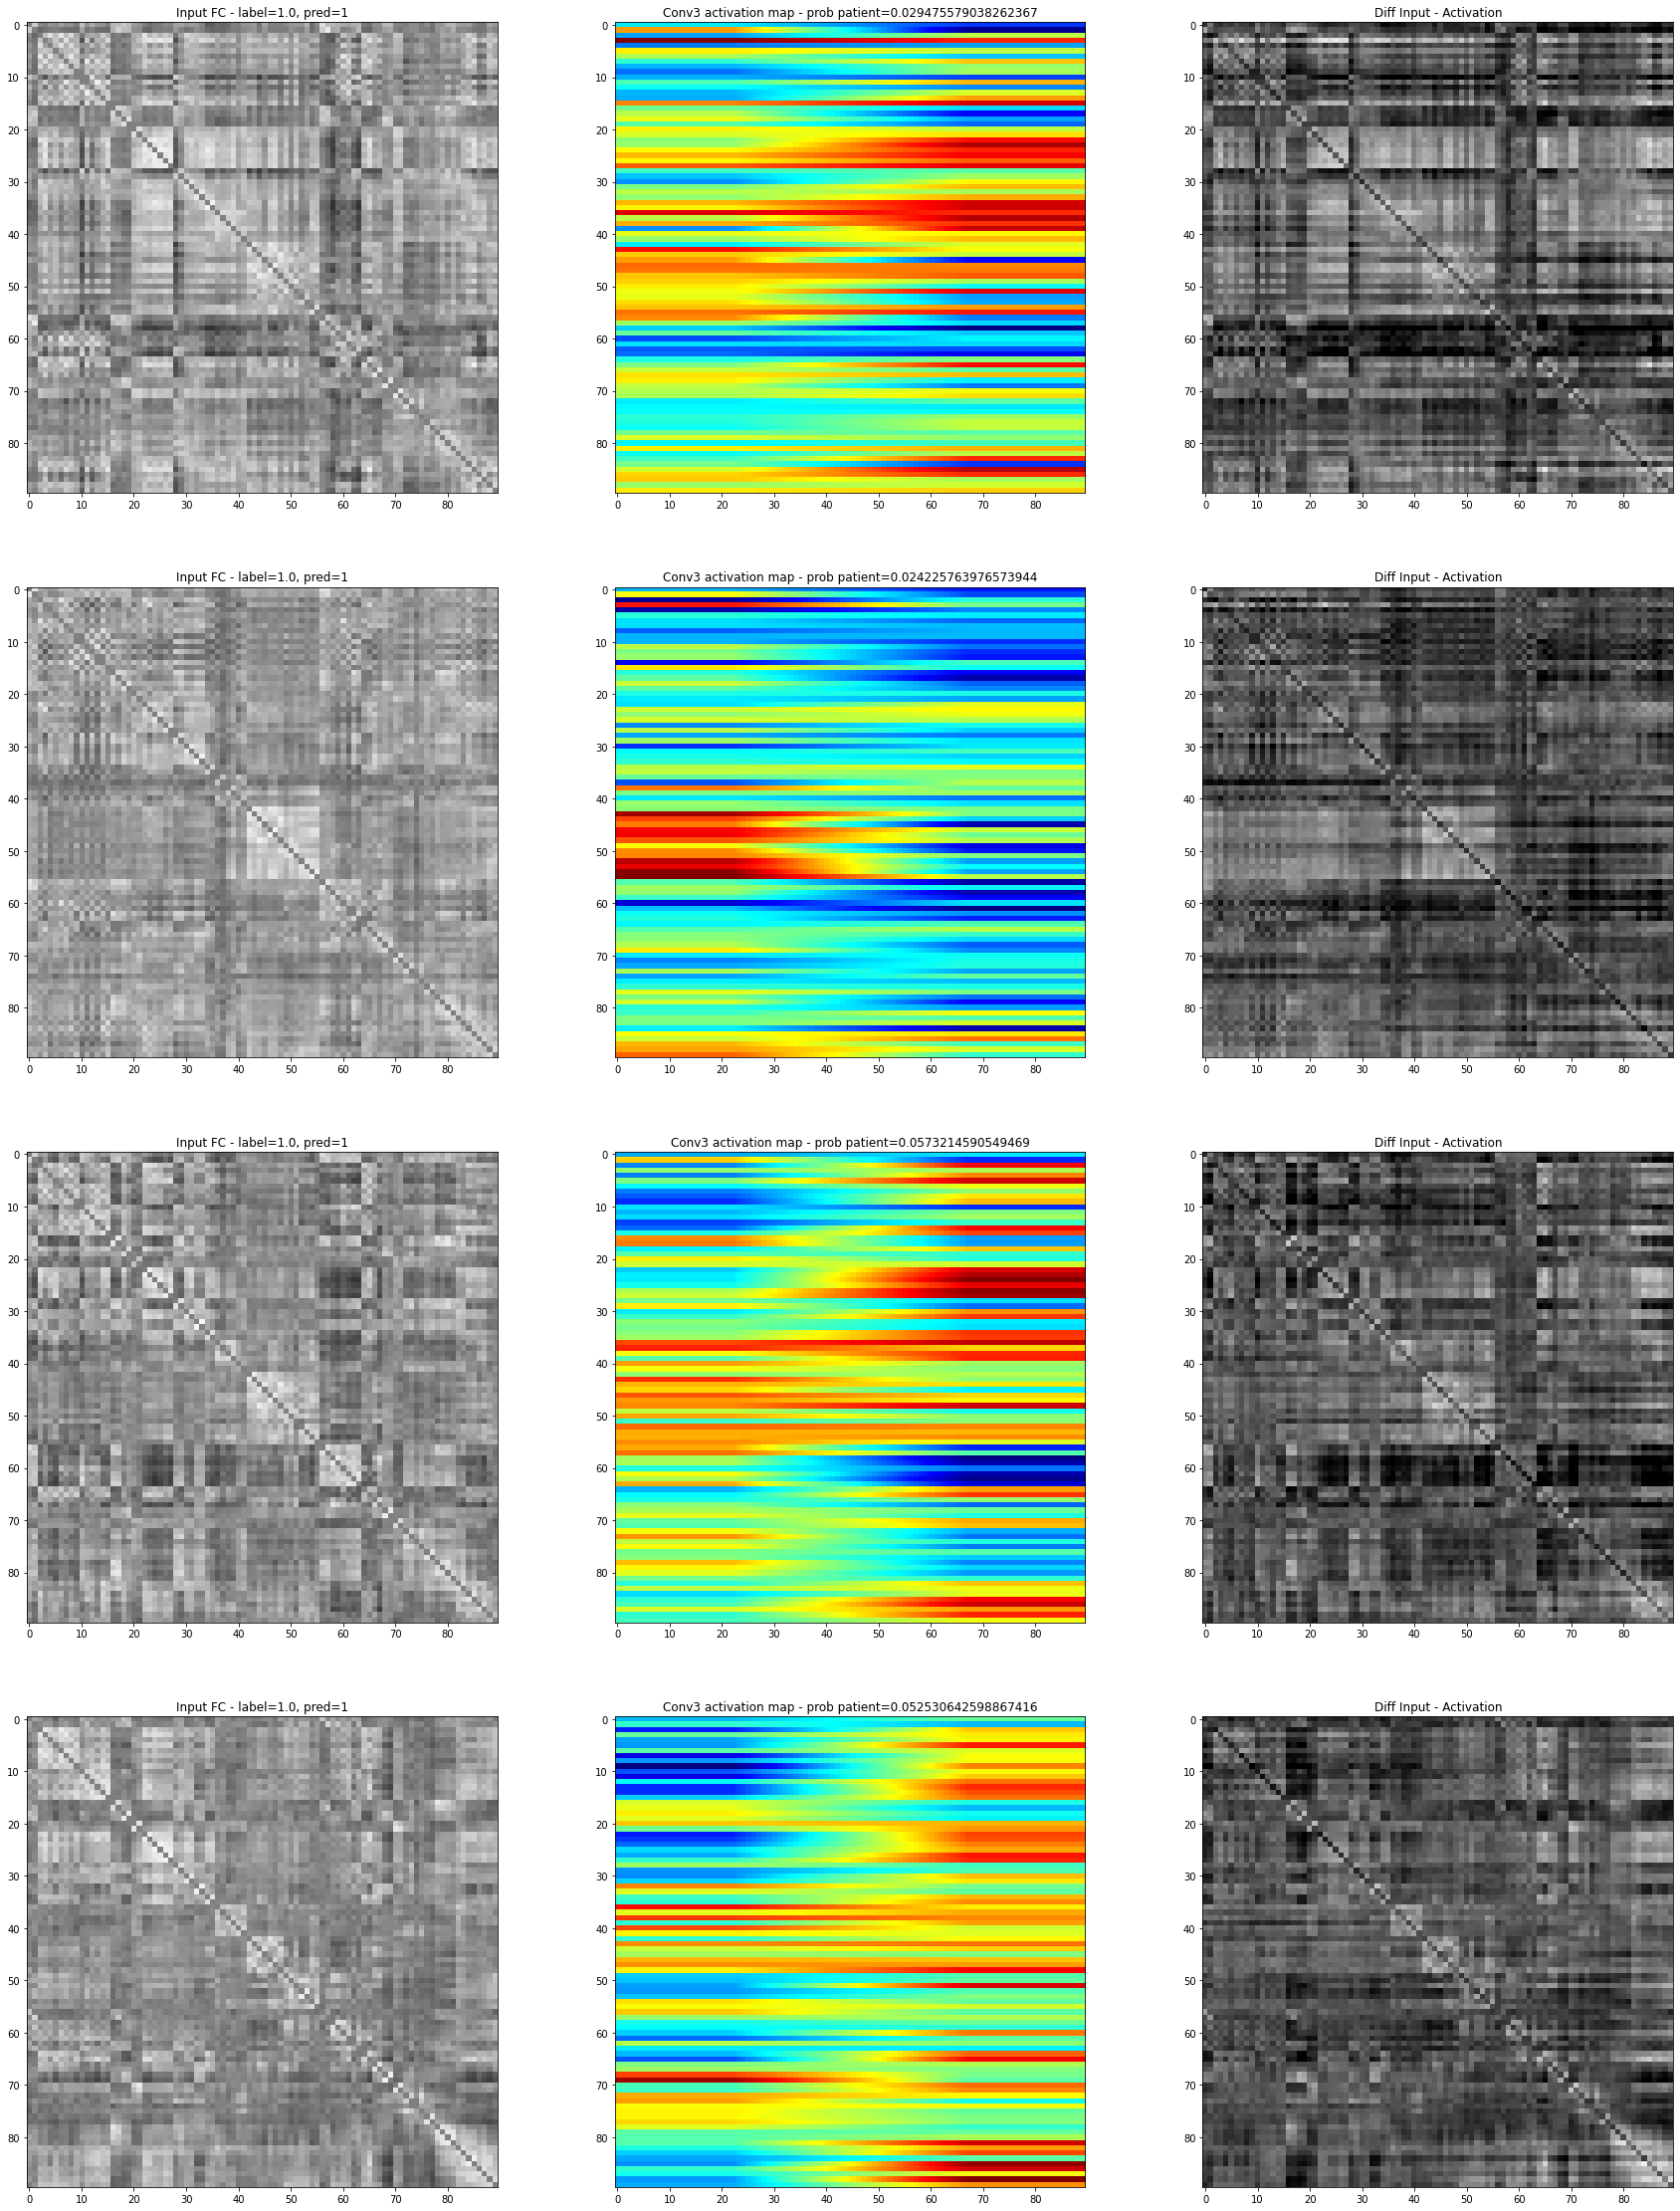

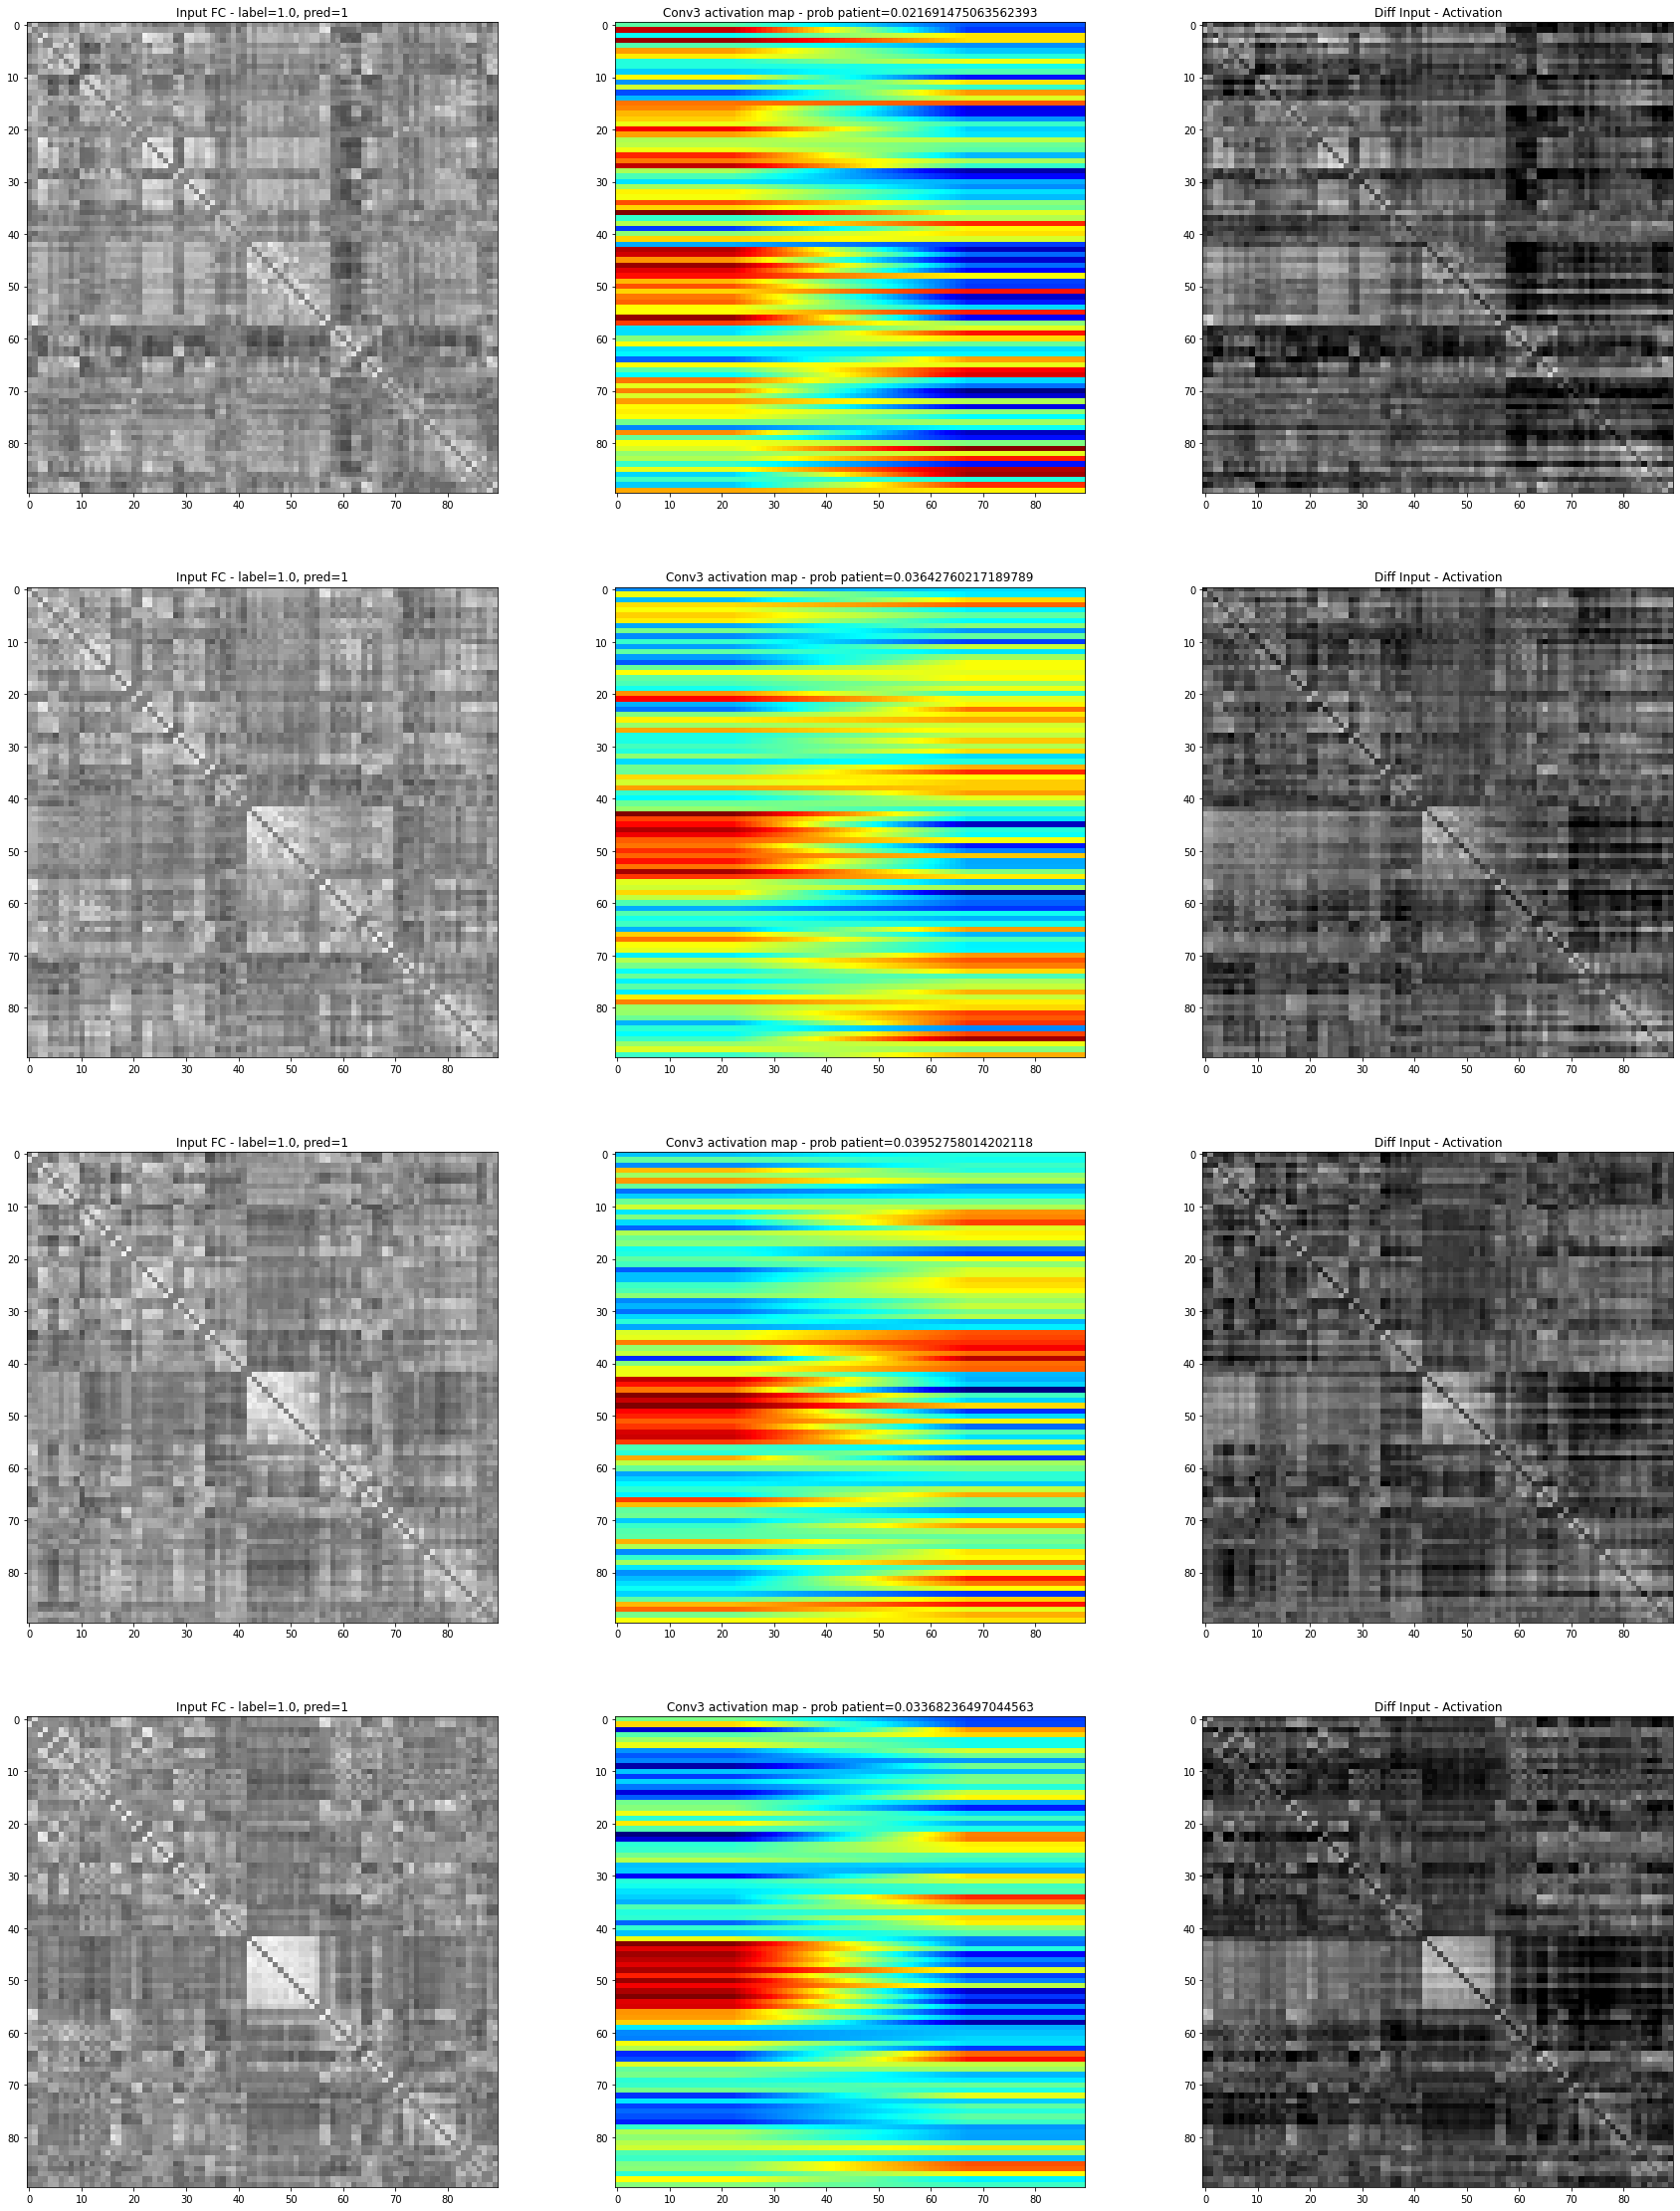

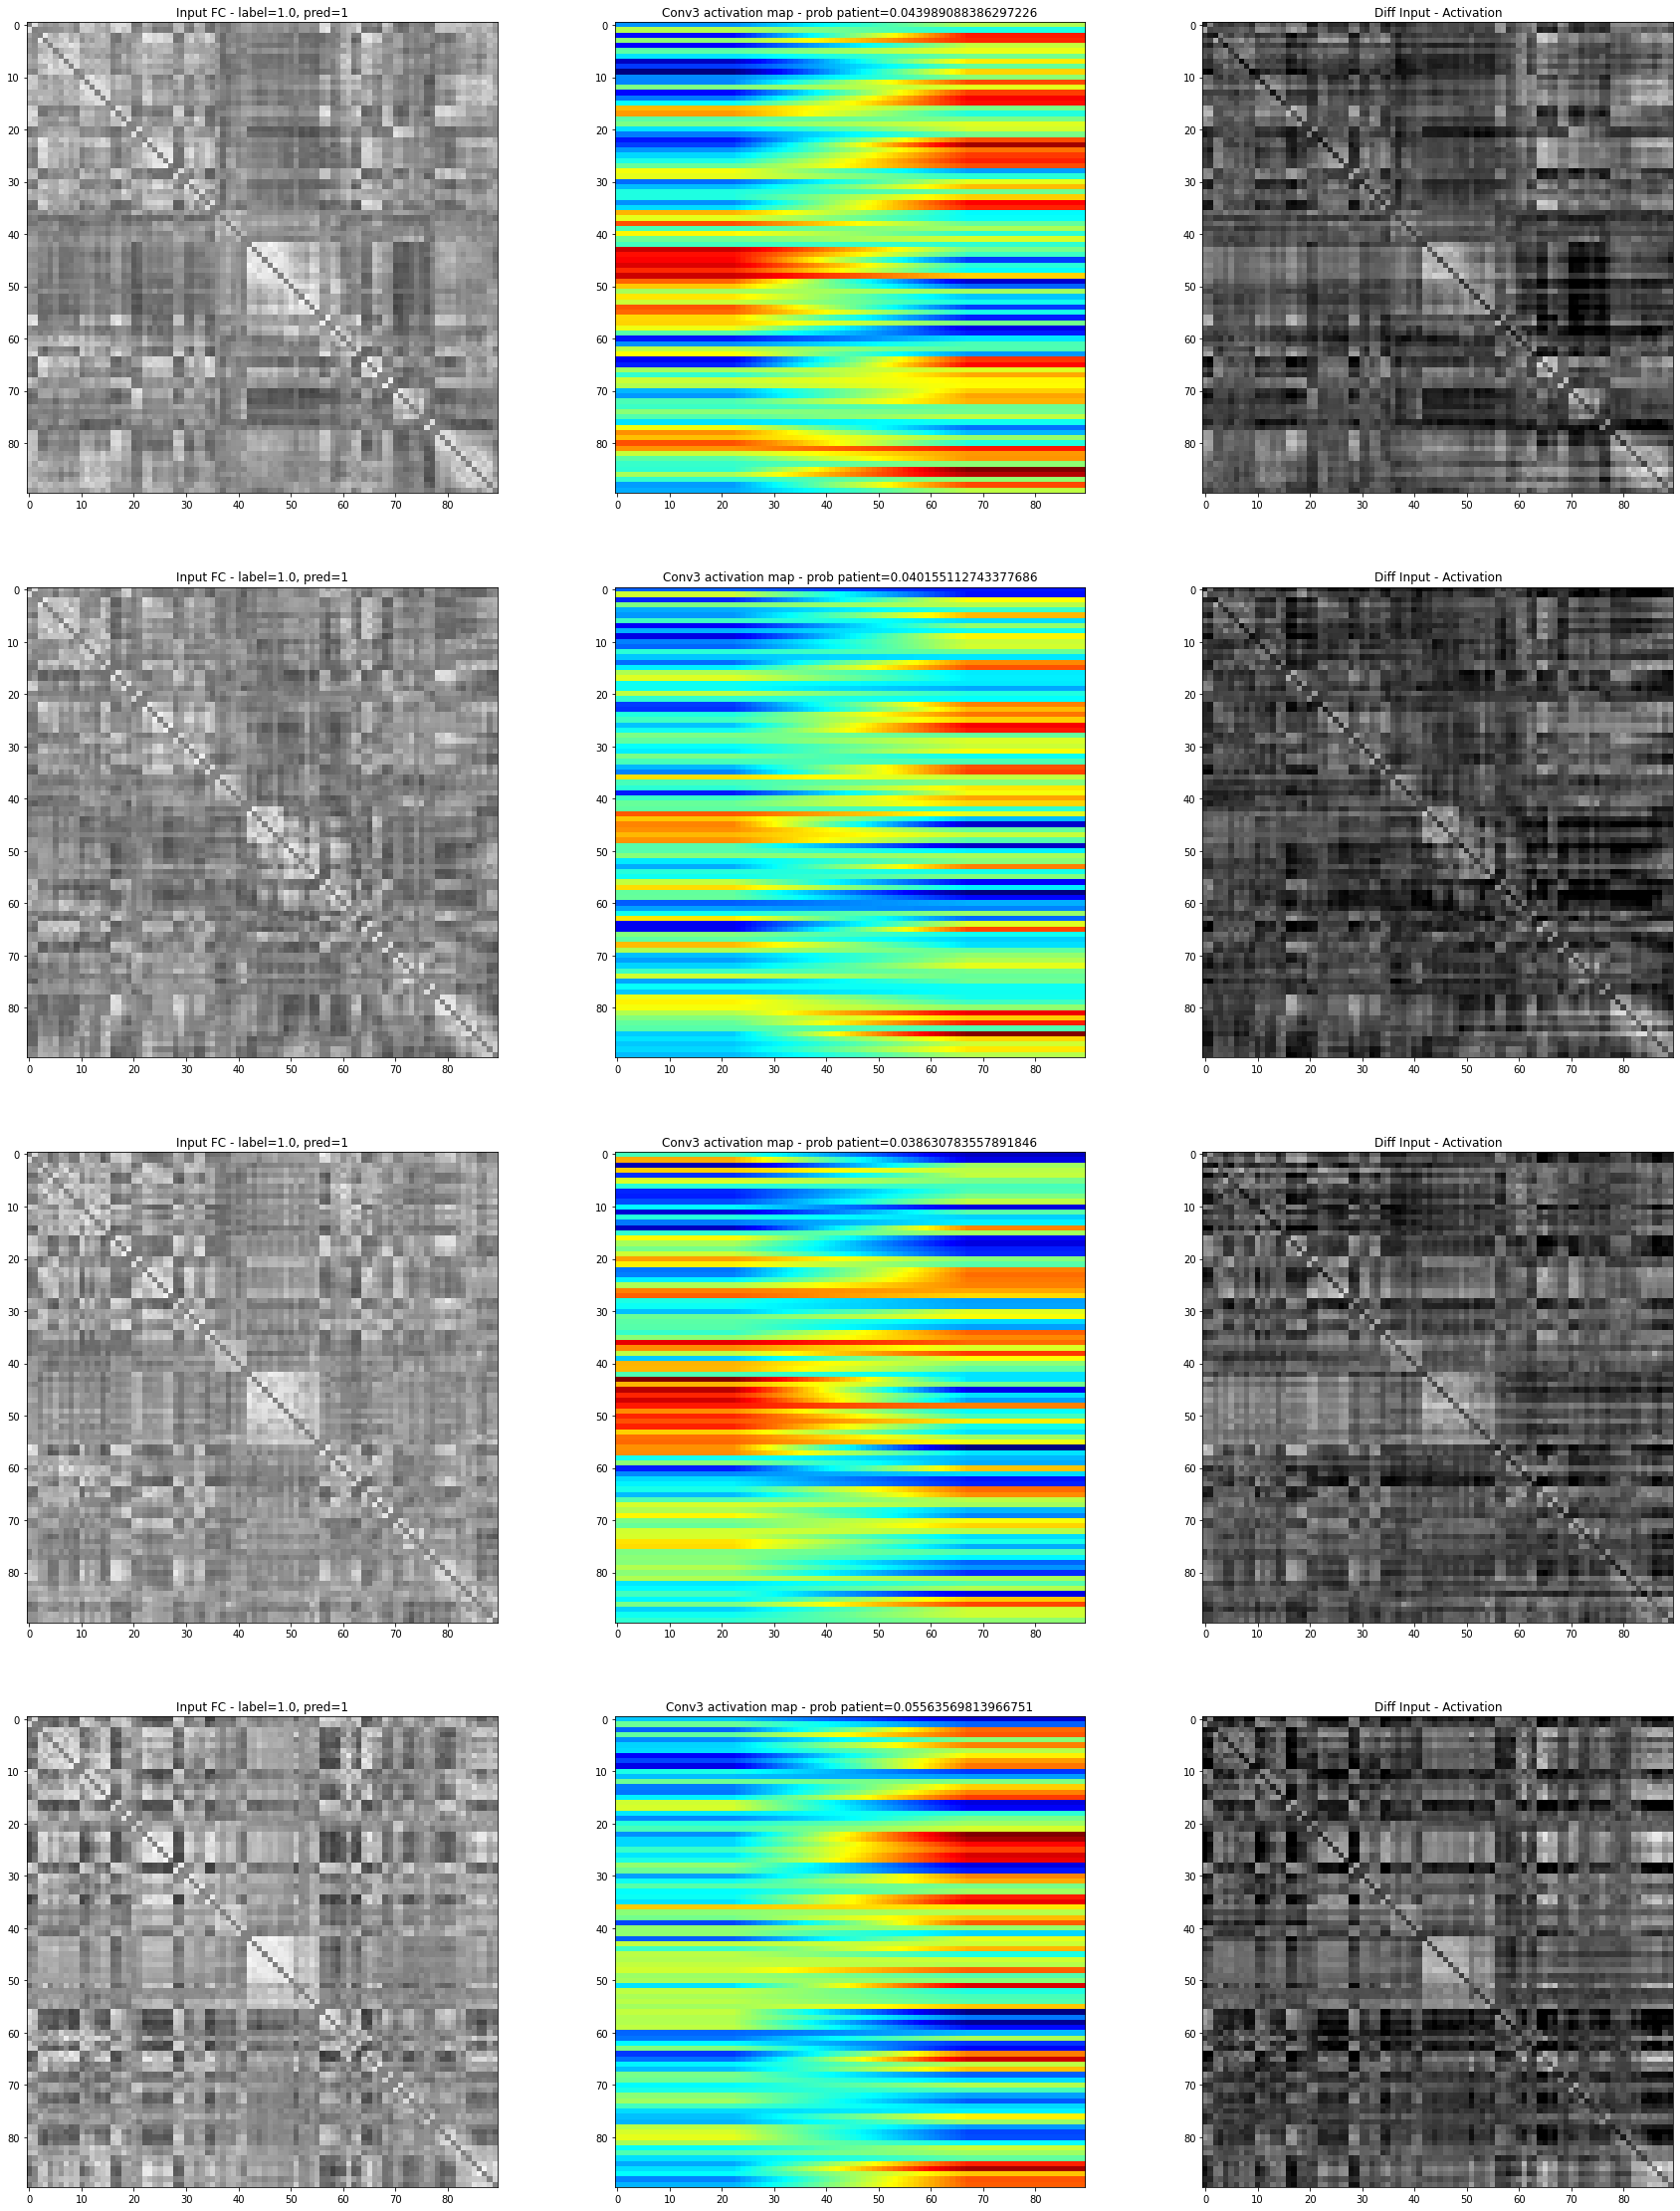

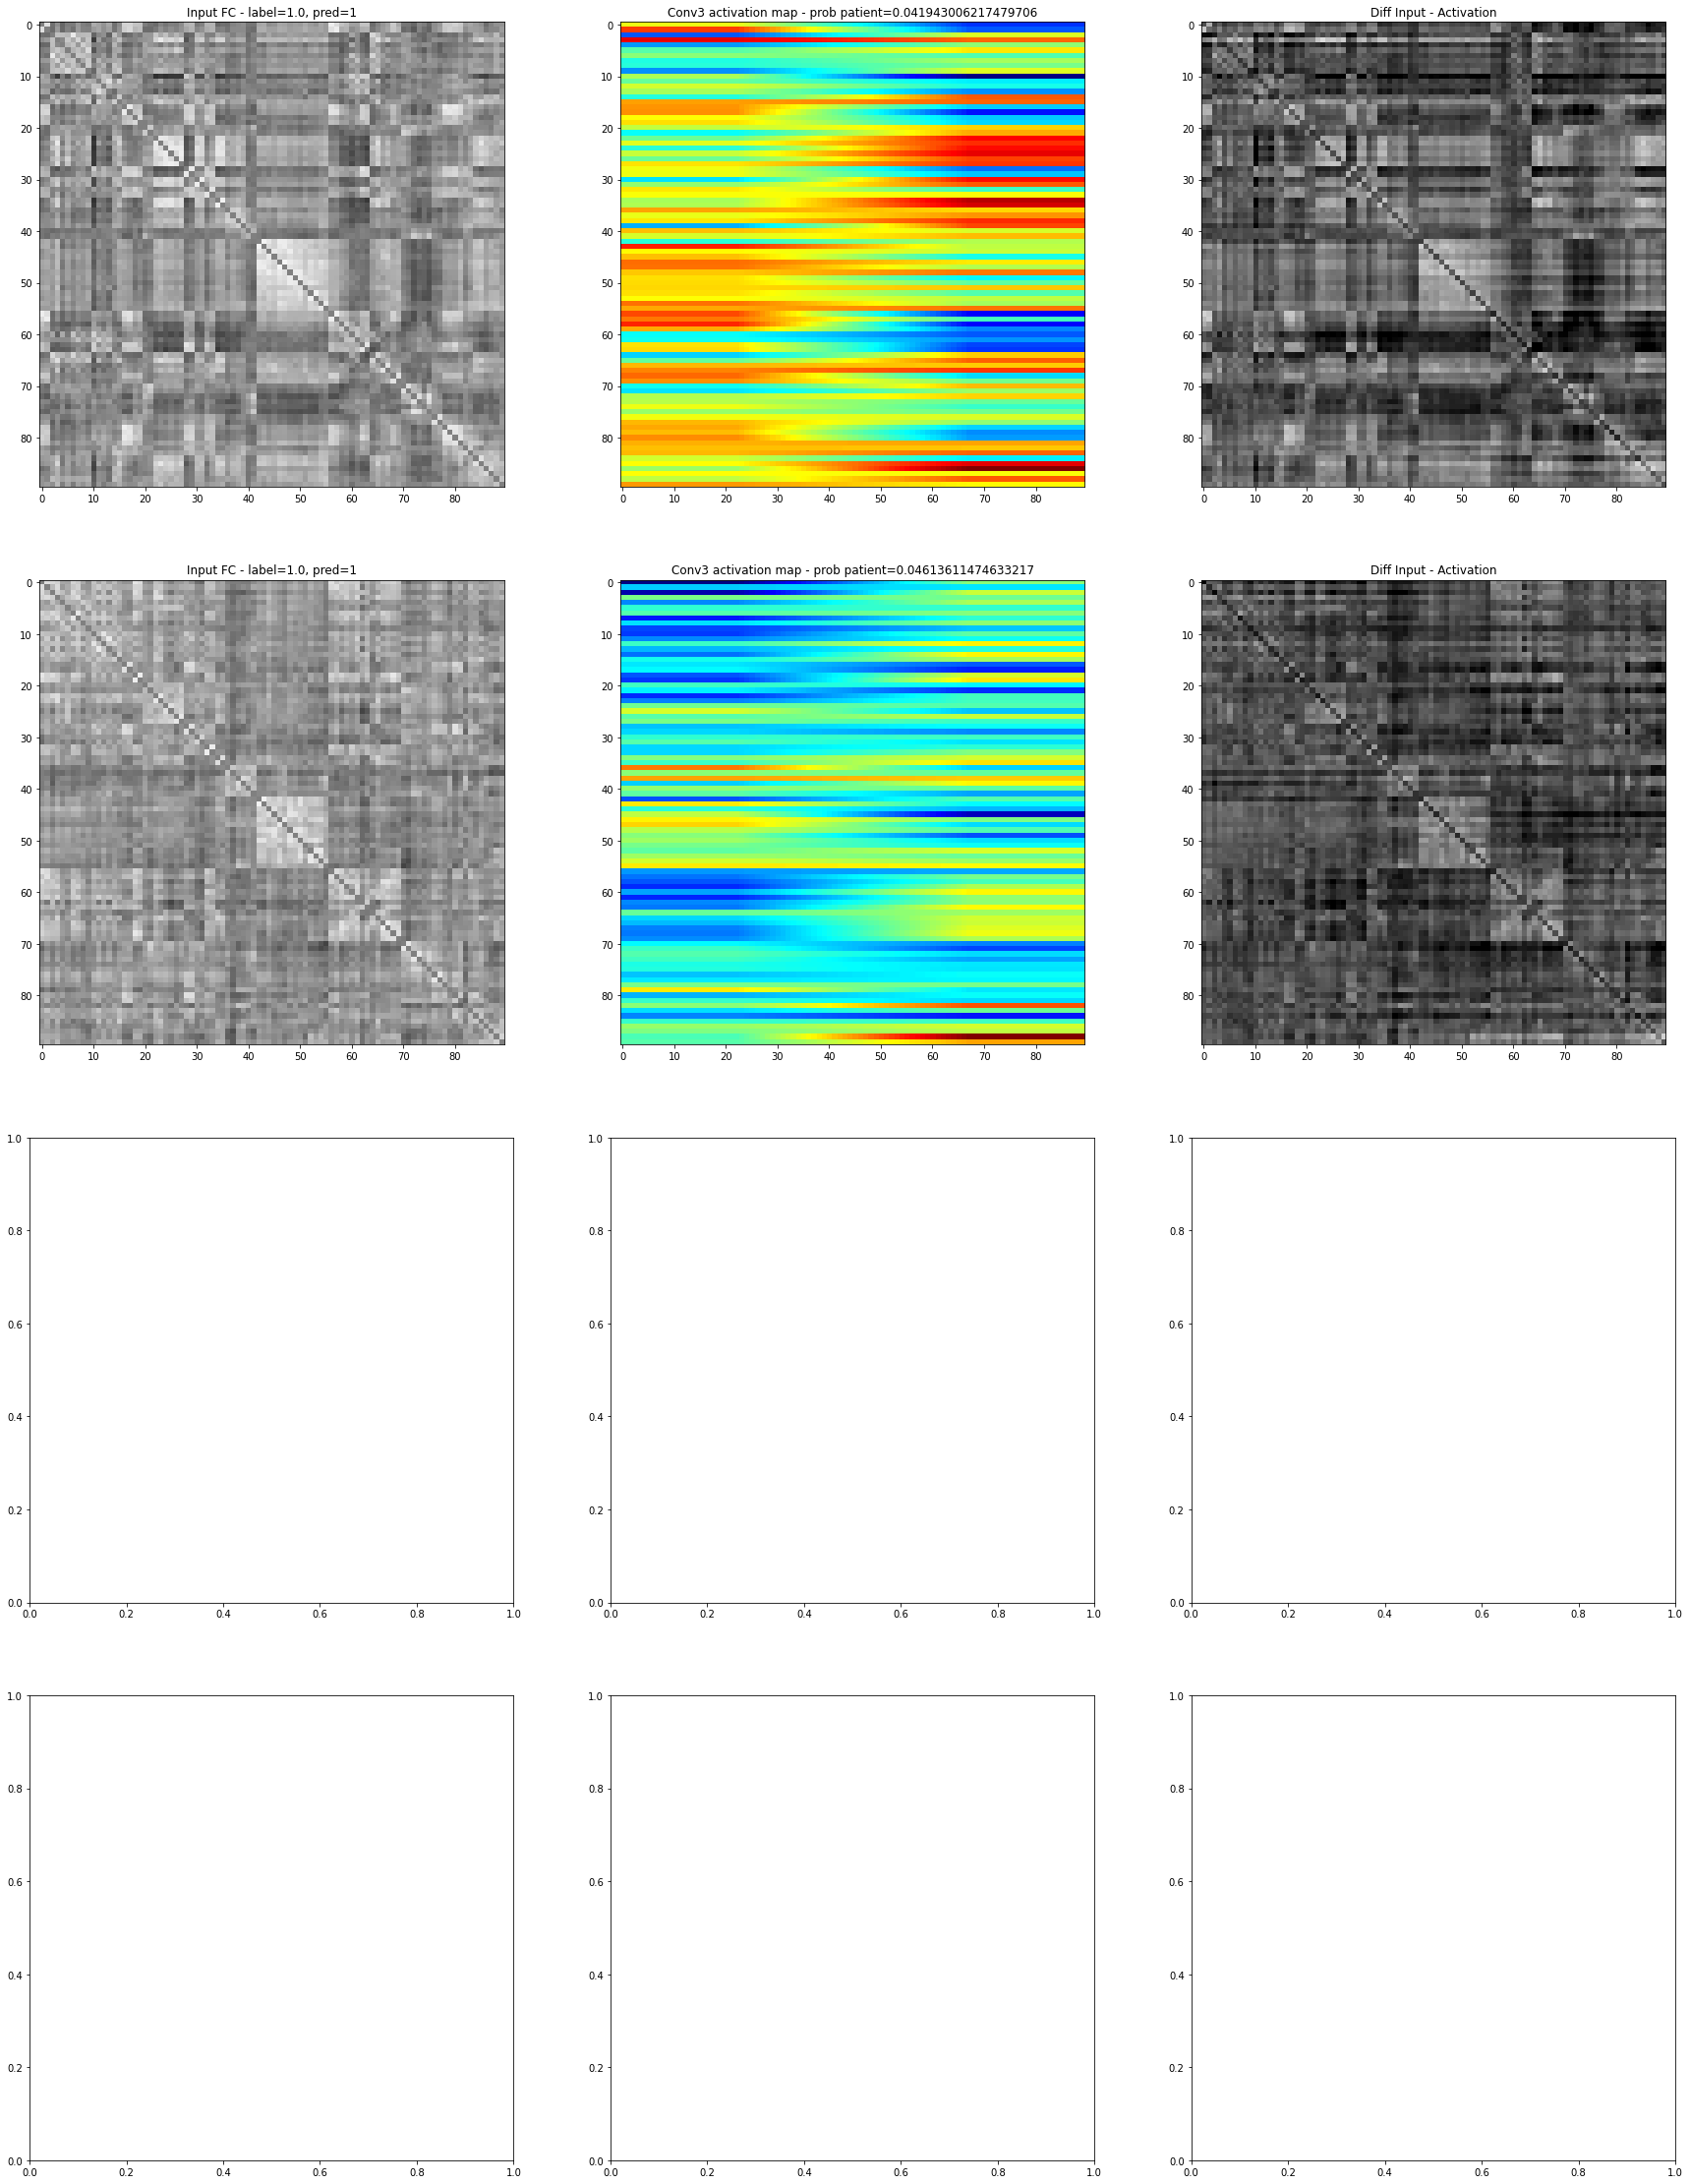

In [101]:
val_data_iterator = iter(valloader)

for input_images, input_labels in val_data_iterator:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_images, target_category=1) #input_labels.squeeze(-1).to(torch.long))

    # Get predictions.
    outputs = net(input_images)
    predicted = torch.where(outputs[:,0] < outputs[:,1], 1, 0)

    # Visualize.
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(30, 40))
    for index_cam, image_cam in enumerate(grayscale_cam):
        input_fc = input_images[index_cam].cpu().reshape(90, 90)
        input_label = input_labels[index_cam].item()
        visualization = show_cam_on_image(np.zeros(shape=(90,90,3)), image_cam)

        ax[index_cam][0].imshow(input_fc, cmap='gray', vmin=-1, vmax=1)
        ax[index_cam][0].set_title(f'Input FC - label={input_label}, pred={predicted[index_cam].item()}')
        ax[index_cam][1].imshow(visualization)
        ax[index_cam][1].set_title(f'Conv3 activation map - prob patient={outputs[index_cam,1]}')
        ax[index_cam][2].imshow(input_fc - image_cam, cmap='gray', vmin=-1, vmax=1)
        ax[index_cam][2].set_title('Diff Input - Activation')

    plt.show()

## Model evalutation

### Only run on test data when the model has been fully trained and best architecture and other settings have been selected.

In [102]:
tp, tn, fp, fn = 0, 0, 0, 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)

        predicted = torch.where(outputs.view(-1) > 0.5, 1, 0)

        total += labels.size(0)

        labels = labels.view(-1)

        pred_positives = predicted == 1
        label_positives = labels == 1

        tp += (pred_positives & label_positives).sum().item()
        tn += (~pred_positives & ~label_positives).sum().item()
        fp += (pred_positives & ~label_positives).sum().item()
        fn += (~pred_positives & label_positives).sum().item()

print(f'Accuracy: {(tp + tn) / total * 100:.2f} %')
print(f'Precision: {tp / (tp + fp) * 100:.2f} %')
print(f'Recall: {tp / (tp + fn) * 100:.2f} %')
print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')

NameError: name 'testloader' is not defined